##Definição de funções

In [1]:
# Instalação de bibliotecas
# !pip install category_encoders

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# from category_encoders import CatBoostEncoder

import pickle

import warnings
warnings.filterwarnings("ignore")

###Metadados

In [2]:
# Função de Metadados
def report_data(df, **kwargs):

  '''
  Função que cria um dataframe resumo de valores missing e outliers no dataframe original
  Argumento obrigatório: dataframe
  Argumento opcional: k (valor do fator de multiplicação para o cálculo do limite de outliers)
  '''

  df2 = pd.DataFrame()
  df2['Feature'] = list(df.columns)
  df2['Tipo'] = df.dtypes.values
  df2['Card'] = df.nunique().values
  df2['qtd miss'] = df.isnull().sum().values
  df2['%Miss'] = round(100 * df2['qtd miss'] / df.shape[0] , 1)


  Q1 = df.quantile(0.25)    #primeiro quartil (percentil 25)
  Q3 = df.quantile(0.75)    #terceiro quartil (percentil 75)
  IIQ = Q3 - Q1             #intervalo interquartil
  k = kwargs.get('k', 1.5)  #Fator multiplicador
  LS = Q3 + k*IIQ           #Limite superior
  LI = Q1 - k*IIQ           #Limite inferior

  df2['qtd out sup'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])>LS].count().values
  df2['%Out_sup'] = round(100 * df2['qtd out sup'] / df.shape[0] , 1)


  df2['qtd out inf'] = df[df.select_dtypes(include=['float64', 'int64', 'float32' , 'int32'])<LI].count().values
  df2['%Out_inf'] = round(100 * df2['qtd out inf'] / df.count().values , 1)

  df2['qtd outliers'] = df2['qtd out sup'] + df2['qtd out inf']
  df2['%Outliers'] = round(100 * df2['qtd outliers'] / df.count().values , 1)


  # Inicialize um DataFrame vazio para armazenar as modas e suas frequências percentuais
  moda_e_frequencia = pd.DataFrame(columns=['Moda', 'Frequência Percentual'])

  # Itere sobre as colunas do DataFrame
  for coluna in df.columns:
      moda_series = df[coluna].mode()

      if not moda_series.empty:
          moda = moda_series.values[0]
          frequencia = (df[coluna] == moda).mean() * 100
          moda_e_frequencia = moda_e_frequencia.append({'Moda': moda, '%Freq': round(frequencia, 1)}, ignore_index=True)
      else:
          # Lidar com o caso em que não há moda (lista vazia)
          moda_e_frequencia = moda_e_frequencia.append({'Moda': None, '%Freq': None}, ignore_index=True)


  df2['Moda'] = moda_e_frequencia['Moda']
  df2['%Freq'] = moda_e_frequencia['%Freq']


  # Quantidade de variáveis com valores faltantes:
  qtd_miss = df2.loc[df2['qtd miss']!= 0,'qtd miss'].count()

  # Quantidade de features numéricas e categóricas
  qtd_numerica = sum(list(df2.loc[(df2['Tipo']=='float') | (df2['Tipo']=='int32')|(df2['Tipo']=='int64'),['Feature']].count()))
  qtd_categorica = sum(list(df2.loc[df2['Tipo']=='object' , ['Feature']].count()))

  # Cálculo da cardinalidade total das variáveis categóricas
  qtd_card_tot = sum(list(df2.loc[(df2['Tipo']=='object') , ['Card']].sum()))

  # Cálculo da quantidade de linhas duplicadas
  dup = df.duplicated().sum()

  # Estilo ANSI para negrito e amarelo
  amarelo = "\033[1;33m"

  # Resetar estilo ANSI (para evitar que o texto seguinte também seja vermelho)
  resetar_estilo = "\033[0m"

  print(f'''{amarelo}
  Quantidade de linhas duplicadas: {dup}  |  Quantidade de features com valores faltantes: {qtd_miss}
  Quantidade de features numéricas: {qtd_numerica}  |  Quantidade de features categóricas {qtd_categorica}
  Cardinalidade total das categóricas: {qtd_card_tot}  |  Dataframe: {df.shape[0]} linhas, {df.shape[1]} colunas
        {resetar_estilo}''')

  # Dropa colunas desnecessárias
  df2.drop(['qtd miss','qtd out sup' , 'qtd out inf', 'qtd outliers'], axis=1 , inplace=True)


  return df2

###Dataprep out-of-sample

In [3]:
def dataprep_out_of_sample(df, target, col_id , metadados, **kwargs):


  #----------------------------------------------------------------------------------------------
  # Argumentos opcionais
  #----------------------------------------------------------------------------------------------

  lim_miss = kwargs.get('lim_miss', 70)
  lim_card = kwargs.get('lim_card', 20)
  convert_target = kwargs.get('convert_target', False)
  encoder_method = kwargs.get('encoder_method', None)
  scaled = kwargs.get('scaled', False)
  stratify = kwargs.get('stratify', 'no')
  # cat_input = kwargs.get('cat_input', 'sem info')
  random_state = kwargs.get('random_state', 42)


  #----------------------------------------------------------------------------------------------
  # Variáveis de entrada da função
  #----------------------------------------------------------------------------------------------

  # df              = tabela analítica de modelagem inicial que será ajustada em uma nova tabela

  # target          = nome da coluna que contém a target

  # col_id          = nome da coluna que contém os ID's. Se não houver ID', passar como 'None'

  # metadados       = metadados da tabela analítica de modelagem inicial

  # convert_target  = True, se for aplicar LabelEncoder na Target, ou False, caso contrário.

  # lim_miss        = limite percentual de valores nulos para dropagem da coluna

  # lim_card        = limite de cardinalidade para utilização do encoder:
  #                   - colunas com cardinalidade menor ou igual ao valor: utilizado OneHotEnconder;
  #                   - colunas com cardinalidade maior que o valor: utilizado LabelEncoder;
  #                   - valor só é útil se o encoder especificado for 'onehot+label'.

  # encoder_method  = método que irá fazer a codificação das variáveis categóricas:
  #                   - 'onehot+label': OneHotEncoder nas de baixa card. e LabelEncoder nas de alta car;
  #                   - 'catboost': CatBoostEncoder em todas as variáveis;
  #                   - None: Não aplica encoder em nenhuma variável categórica (se houver).

  # scaled          = Informa quais variáveis serão padronizadas:
  #                   - False: nenhuma variável;
  #                   - True: todas as variáveis;
  #                   - 'num': se houver variáveis categóricas, será aplicado nas originalmente numéricas.

  # stratify        = Informa se o split de dados de treino/teste será estratificado em relação à tareget

  # cat_input       = Valor para imputação das categóricas com valores nulos (foi inutilizado)

  # random_state    = valor paraa semente aleatória para split dos dados de treino e teste


  #----------------------------------------------------------------------------------------------
  # Descrição
  #----------------------------------------------------------------------------------------------

  # Função para automação da etapa de preparação dos dados
  # Esta função salva as diversas etapas de transformação dos
  # dados de treino (X_train) e de teste (X_test).
  # A função também retorna todos os conjuntos de dados e os artefatos
  # utilizados na transformação, como os encoders, o scaler, as medianas imputadas, etc


  #----------------------------------------------------------------------------------------------
  # Exemplo de uso
  #----------------------------------------------------------------------------------------------

  # dataprep_01 = dataprep_out_of_time(df=abt_00, target='Default', metadados=metadados_00,
  #                                     lim_miss=70, lim_card=20, scaled=False,
  #                                     encoder_method='onehot+label', convert_target=False)


  #----------------------------------------------------------------------------------------------
  # Separando dados de treino e teste antes de qualquer manipulação - evitar DataLeakage
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.model_selection import train_test_split

  # Divisão X e Y
  X = df.drop(target, axis=1)
  y = df[target]

  # Divisão treino e teste
  if stratify=='no':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)                  #sem estratificação
  elif stratify == 'yes':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)      #estratifica pela target


  #----------------------------------------------------------------------------------------------
  # Salvando backup das colunas com os dados de ID's
  #----------------------------------------------------------------------------------------------

  # Se não foi informada a coluna de ID's...
  if col_id == None:

    # Armazena uma string nao invés dos ID's
    col_id_train = 'Não informado'
    col_id_test = 'Não informado'


  # Se a coluna de ID's foi informada...
  else:

    # Backup da coluna onde estão os ID's dos dados de treino e dos dados de teste
    col_id_train = X_train[col_id]   #treino
    col_id_test = X_test[col_id]     #teste

    # Dropando a coluna de ID's dos dados de treino e dos dados de teste
    X_train.drop(col_id, axis=1, inplace=True)   #treino
    X_test.drop(col_id, axis=1, inplace=True)    #teste


  #----------------------------------------------------------------------------------------------
  # Dropando colunas com alto percentual de missing
  #----------------------------------------------------------------------------------------------

  # Limites
  lim_miss = lim_miss

  # Lista de variáveis com miss acima do limiar
  list_var_drop = list(metadados.loc[metadados['%Miss'] > lim_miss, 'Feature'])

  # Dropando em X_train
  X_train.drop(list_var_drop, axis=1, inplace=True)

  # Dropando em X_test
  X_test.drop(list_var_drop, axis=1, inplace=True)


  #----------------------------------------------------------------------------------------------
  # Definindo colunas numéricas e categóricas
  #----------------------------------------------------------------------------------------------

  num_var = list(X_train.select_dtypes(include=('int32','int64','float')).columns)
  cat_var = list(X_train.select_dtypes(include='object').columns)


  #----------------------------------------------------------------------------------------------
  # Imputando valores
  #----------------------------------------------------------------------------------------------

  # Dicionário vazio para armazenar os inputs de miss
  list_miss_input = {}

  # Iterando pelas colunas numéricas
  for i in num_var:
    # Verificando se existe valor nulo na coluna
    if X_train[i].isna().any() == True:
      mediana = X_train[i].median()                   #Econtra a mediana a partir dos daods de treino
      X_train[i].fillna(mediana , inplace=True)       #Imputa a mediana nos dados de treino
      X_test[i].fillna(mediana , inplace=True)        #Imputa a mediana nos dados de teste
      list_miss_input[i] = mediana                    #Acrescenta o par chave/valor ao dicionário

  # Iterando pelas colunas categóricas
  for i in cat_var:

    # Verificando se existe valor nulo na coluna
      X_train[i].fillna('sem info' , inplace=True)    #Imputa a mediana nos dados de treino
      X_test[i].fillna('sem info' , inplace=True)     #Imputa a mediana nos dados de teste
      list_miss_input[i] = 'sem info'                 #Acrescenta o par chave/valor ao dicionário
      # Observação:
      # não imputar strings com "underline"
      # para não afetar no rastrei das dummies
      # que possuem o sufixo '_dummy'


  #----------------------------------------------------------------------------------------------
  # Codificação da target
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import LabelEncoder

  if convert_target == True:      #Caso a target precise ser convertida
    # Instanciando
    encoder_target = LabelEncoder()

    # Aplicando treino e teste
    y_train = encoder_target.fit_transform(y_train)     #Fit e transform
    y_test = encoder_target.transform(y_test)           #Apenas transform

  elif convert_target == False:   # Caso a target não precise ser convertida
    encoder_target = 'Não aplicado'


  #----------------------------------------------------------------------------------------------
  # Codificação de variáveis categóricas
  #----------------------------------------------------------------------------------------------

  # Caso não seja aplicado nenhum encoder nas variáveis
  if encoder_method == None:
      X_train_enc = 'Não aplicado'
      X_test_enc = 'Não aplicado'

  #Caso seja aplicado algum encoder nas variáveis
  else:

      # Copiando
      X_train_enc = X_train.copy()
      X_test_enc = X_test.copy()

      # Limite de cardinalidade para aplicar um ou outro encoder
      lim_card = lim_card

      # Separando variáveis de alta e baixa cardinalidade
      alta_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() > lim_card])
      baixa_card = list(X_train[cat_var].columns[X_train[cat_var].nunique() <= lim_card])

      # Se foi definido OneHotEncoder + LabelEncoder
      if encoder_method == 'onehot+label':

          # Importando os pacotes
          from sklearn.preprocessing import LabelEncoder, OneHotEncoder

          # Instanciando - Label Encoder nas de alta cardinalidade
          # >>> Necessário fazer um loop para salvar o Encoder de cada feature numa lista
          # >>> Label encoder não dá pra aplicar em mais de uma Feature
          label_encoder = LabelEncoder()

          # Inicializa um dicionário para salvaro label encoder de cada coluna
          dict_label_encoder = {}

          # Label encoder - alta cardinalidade
          for i in alta_card:
              X_train_enc[i] = label_encoder.fit_transform(X_train_enc[i]) #Fit_transform nos dados de treino
              X_test_enc[i] = label_encoder.transform(X_test_enc[i])       #Somente transform nos dados de teste
              dict_label_encoder[i] = label_encoder                        #Salva o encoder. A chave é a coluna i, e o valor é o encoder

          # Crie e aplique o OneHotEncoder
          OneHot_encoder = OneHotEncoder(sparse=False, drop='first')

          # Aplicando OneHotEncoding nos conjuntos de treino e teste
          encoded_data = OneHot_encoder.fit_transform(X_train_enc[baixa_card]) #Fit_transform nos dados de treino

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_cols = OneHot_encoder.get_feature_names_out(baixa_card)
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=X_train_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_train
          X_train_enc = pd.concat([X_train_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

          # Aplicando OneHotEncoding em X_test
          encoded_data = OneHot_encoder.transform(X_test_enc[baixa_card]) #Somente transform nos dados de teste

          # Criando dataframe com as colunas codificadas, mantendo o índice original
          encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=X_test_enc.index)

          # Concatenando o dataframe codificado com o dataframe original em X_test
          X_test_enc = pd.concat([X_test_enc.drop(baixa_card, axis=1), encoded_df], axis=1)

      # Se foi definido Catboost
      elif encoder_method == 'catboost':

          # Importando o pacote
          from category_encoders import CatBoostEncoder

          # Instanciando
          cat_encoder = CatBoostEncoder(cols=cat_var)

          # Aplicando as transformações
          X_train_enc = cat_encoder.fit_transform(X_train_enc, y_train)  #fit.transform
          X_test_enc = cat_encoder.transform(X_test_enc)                 #somente "transform"


  #----------------------------------------------------------------------------------------------
  # Padronização dos dados (não precisa para árvores)
  #----------------------------------------------------------------------------------------------

  # Importando o pacote
  from sklearn.preprocessing import StandardScaler

  # Se foi selecionado algum encoder para categorizar as variáveis
  if encoder_method != None:

      # Criando cópia dos dados categorizados
      X_train_enc_std = X_train_enc.copy()
      X_test_enc_std = X_test_enc.copy()

      # Instanciando
      scaler = StandardScaler()

      # Se foi selecionado que o scaler será aplicado somente nas colunas originalmente numéricas
      # Ou seja, encoder nas categóricas + scaler nas numéricas
      if scaled == 'num':
          qtd_scaler = len(num_var)  # Quantidade de variáveis (igual a quantidade de numéricas) ao qual foi aplicado o scaler
          list_var_scaled = num_var  # Lista de variáveis que passarão pelo scaler, que é a lista de variáveis originalmente numéricas
          X_train_enc_std[num_var] = scaler.fit_transform(X_train_enc_std[num_var])  # Aplica fit_transform nos dados de treino
          X_test_enc_std[num_var] = scaler.transform(X_test_enc_std[num_var])        # Somente transform nos dados de teste

      # Se foi selecionado que o scaler será aplicado em todas as colunas (numéricas e categóricas) (após o encoder das categóricas)
      # Ou seja, encoder nas categóricas + scaler em todas
      elif scaled == True:
          qtd_scaler = len(list(X_train_enc.columns))         # Quantidade de variáveis da base categorizada ao qual foi aplicado o scaler
          list_var_scaled = list(X_train_enc.columns)         # Lista de variáveis da base categorizada que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, somente encoder nas categóricas e sem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'


  # Se não foi selecionado nenhum encoder, também não deixa padronizar nada <<<
  # Ou seja, não aplica nem encoder nas categóricas, >>> e nem scaler em nada <<<
  elif encoder_method == None:

      # Criando cópia para os dados padronizados
      X_train_enc_std = X_train.copy() # Nota: o termo "_enc_" foi mantido apenas
      X_test_enc_std = X_test.copy()   # para que não se tenha necessidade de
                                       # ajustar mais o código mas, na verdade
                                       # esses dados não passaram por encoder
                                       # e foram copiados diretamente
                                       # de X_train e X_test. Nesse caso, nas linhas
                                       # acima, X_train_enc e X_test_enc já receberam
                                       # o valor "Não aplicado"

      # Se foi selecionado que o scaler será aplicado somente nas numéricas. Nesse caso, se não houver categóricas, todas as features serão padronizadas
      # Ou seja, sem encoder em nenhuma categórica + scaler em todas as numéricas
      if scaled == 'num':
          qtd_scaler = len(list(X_train.columns))  # Quantidade de variáveis ao qual foi aplicado o scaler
          list_var_scaled = list(X_train.columns)  # Lista de variáveis que passarão pelo scaler
          X_train_enc_std = pd.DataFrame(scaler.fit_transform(X_train_enc), columns=X_train_enc.columns)  # Aplica fit_transform nos dados de treino
          X_test_enc_std = pd.DataFrame(scaler.transform(X_test_enc), columns=X_test_enc.columns)         # ASomente transform nos dados de teste

      # Se foi selecionado que não será aplicado scaler em nenhuma variável
      # Ou seja, nem encoder nas categóricas e nem scaler em nada
      elif scaled == False:
        scaler = 'Não aplicado'
        qtd_scaler = 'Não aplicado'
        list_var_scaled = 'Não aplicado'
        X_train_enc_std = 'Não aplicado'
        X_test_enc_std = 'Não aplicado'



  #----------------------------------------------------------------------------------------------
  # Objetos finais
  #----------------------------------------------------------------------------------------------

  # Se não foi usado nenhum encoder
  if encoder_method == None:

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: Não aplicado
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado'''

  # Se foi utilizado OneHotEncoder + LabelEncoder
  elif encoder_method == 'onehot+label':

      one_hot_enc = OneHot_encoder
      label_enc = dict_label_encoder
      catboost_enc = 'Não aplicado'
      list_var_OneHotEncoder = baixa_card
      list_var_LabelEncoder = alta_card
      list_var_CatBoostEncoder = 'Não aplicado'

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: {len(baixa_card)}
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: {len(alta_card)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''

  # Se foi utilizado CatboostEncoder
  elif encoder_method == 'catboost':

      one_hot_enc = 'Não aplicado'
      label_enc = 'Não aplicado'
      catboost_enc = cat_encoder
      list_var_OneHotEncoder = 'Não aplicado'
      list_var_LabelEncoder = 'Não aplicado'
      list_var_CatBoostEncoder = cat_var

      # Resumo
      resume = f'''Resumo dataprep:\n
      • Limite de cardinalidade adotado: {lim_card}
      • Limite de percentual de nulos adotado: {lim_miss}%
      • Quantidade de variáveis dropadas por nulos: {len(list_var_drop)}
      • Quantidade de variáveis ao qual foi aplicado CatBoostEncoder: {len(cat_var)}
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: {qtd_scaler}'''



  class DataPrepResult:
      def __init__(self, X_train, X_train_enc, X_train_enc_std, X_test,
                    X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                    list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                    list_var_scaled, list_var_drop, list_miss_input,
                    one_hot_enc, label_enc, catboost_enc, encoder_target,
                    col_id_train , col_id_test, resume):

          self.X_train = X_train
          self.X_train_enc = X_train_enc
          self.X_train_enc_std = X_train_enc_std
          self.X_test = X_test
          self.X_test_enc = X_test_enc
          self.X_test_enc_std = X_test_enc_std
          self.y_train = y_train
          self.y_test = y_test
          self.scaler = scaler
          self.list_var_OneHotEncoder = list_var_OneHotEncoder
          self.list_var_LabelEncoder = list_var_LabelEncoder
          self.list_var_CatBoostEncoder = list_var_CatBoostEncoder
          self.list_var_scaled = list_var_scaled
          self.list_var_drop = list_var_drop
          self.list_miss_input = list_miss_input
          self.one_hot_enc = one_hot_enc
          self.label_enc = label_enc
          self.catboost_enc = catboost_enc
          self.encoder_target = encoder_target
          self.col_id_train = col_id_train
          self.col_id_test = col_id_test
          self.resume = resume



  return DataPrepResult(X_train, X_train_enc, X_train_enc_std, X_test,
                        X_test_enc, X_test_enc_std, y_train, y_test, scaler,
                        list_var_OneHotEncoder, list_var_LabelEncoder, list_var_CatBoostEncoder,
                        list_var_scaled, list_var_drop, list_miss_input,
                        one_hot_enc, label_enc, catboost_enc, encoder_target,
                        col_id_train , col_id_test, resume)


###Feature selection por Feature Importance

In [4]:
def fs_importance(model, X, y, cutoff_importance, plot, figsize=None, model_name=None):

  # Treinamento
  model.fit(X, y)

  # Extraindo a importância das variáveis
  feature_importances = model.feature_importances_
  features = pd.DataFrame({ 'Feature': X.columns, 'Importance': feature_importances })

  # Ordenar variáveis por importância
  features = features.sort_values(by='Importance', ascending=False)

  # Estabelecer um limite de corte, por exemplo, x% da importância máxima
  cutoff_maximp = cutoff_importance

  cutoff = cutoff_maximp * feature_importances.max()

  # Selecionar variáveis acima do corte
  selected_features = X.columns[feature_importances >= cutoff].tolist()

  # Selecionar variáveis abaixo do corte
  not_selected_features = X.columns[feature_importances < cutoff].tolist()

  # Visualizando a importância das variáveis em barras horizontais
  if figsize==None:
    plt.figure(figsize=(10, 6))
  else:
    plt.figure(figsize=figsize)

  sorted_idx = feature_importances.argsort()

  print(f'\nFeatures removidas: {len(not_selected_features)}')

  print(f'Features remanescentes: {len(selected_features)}\n')

  lim_plot = 60 #Limite de variáveis para plotar o gráfico

  if plot==True: #and len(features) <= lim_plot:
    plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx], color='dodgerblue')  # tom de azul claro
    plt.xlabel("Feature Importance")
    if model_name == None:
      plt.title(f"Feature Importance")
    else:
      plt.title(f"Feature Importance com {model_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.axvline(x=cutoff, color='r', linestyle='--', label=f'Ponto de corte = {100*cutoff_maximp:.1f} %\nda importância máxima')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
  else:
    print(f'\033[1;33mO gráfico não será exibido pois a quantidade total de features é maior que {lim_plot}.\033[0m\n')

  return selected_features

###Feature selection por Information Value

In [5]:
# Feature selection com IV Values
  # Utilizado quando se tem target binário
  # Recomendado ser implementado num conjunto já reduzido
  # por uma etapa preliminar de feature selection
  # Pode captar variáveis preditoras "Fracas", que passaram pelas
  # etapas anteriores. Assim, pode-se removê-las diretamente nesta etapa
  # ou voltar á etapa anterior e "apertar" o funil (que é a sugestão)

# Função para discretizar as variáveis numéricas
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

# Função para calcular o IV de uma variável já discretizada
def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()


# Função que avalia e retorna o IV da variável
def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# Função que chama todas as outras e cria um dataframe com a IV de cada variável
# Observação passar o dataframe inteiro (ao invés de só as explicativas) e especificar a target
def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

###Cálculo de métricas

In [6]:
def calculate_metrics(model_name, model, X_train, y_train, X_test, y_test):

    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1    #Cálculo do Gini

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) #Na coluna de indice 1 está a probabilidade de o evento ser 1

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1    #Cálculo do Gini

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [model_name, model_name],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import pandas as pd
import numpy as np

def calculate_metrics2(train_df, test_df, score_column, target_column,bins=10):
    def compute_metrics(df, score_column, target_column):
        df_sorted = df.sort_values(by=score_column, ascending=False)

        # Calcular KS
        df_sorted['cum_good'] = (1 - df_sorted[target_column]).cumsum() / (1 - df_sorted[target_column]).sum()
        df_sorted['cum_bad'] = df_sorted[target_column].cumsum() / df_sorted[target_column].sum()
        df_sorted['ks'] = np.abs(df_sorted['cum_good'] - df_sorted['cum_bad'])
        ks_statistic = df_sorted['ks'].max()

        # Calcular AUC
        auc_value = roc_auc_score(df_sorted[target_column], df_sorted[score_column])

        # Calcular Gini
        gini = 2 * auc_value - 1

        # Dividir o score em 10 faixas
        df_sorted['decile'] = pd.qcut(df_sorted[score_column], bins, labels=False)

        # Criar tabela detalhada
        table = df_sorted.groupby('decile').agg(
            min_score=pd.NamedAgg(column=score_column, aggfunc='min'),
            max_score=pd.NamedAgg(column=score_column, aggfunc='max'),
            event_rate=pd.NamedAgg(column=target_column, aggfunc='mean'),
            volume=pd.NamedAgg(column=target_column, aggfunc='size')
        ).reset_index()

        return ks_statistic, auc_value, gini, table

    ks_train, auc_train, gini_train, table_train = compute_metrics(train_df, score_column, target_column)
    ks_test, auc_test, gini_test, table_test = compute_metrics(test_df, score_column, target_column)

    # Plotando o gráfico de barras para Event Rate por Decil
    barWidth = 0.3
    r1 = np.arange(len(table_train))
    r2 = [x + barWidth for x in r1]

    plt.bar(r1, table_train['event_rate'], color='lightblue', width=barWidth, label='Train')
    plt.bar(r2, table_test['event_rate'], color='royalblue', width=barWidth, label='Test')

    plt.xlabel('Decile')
    plt.ylabel('Event Rate')
    plt.title('Event Rate by Decile')
    plt.xticks([r + barWidth for r in range(len(table_train))], table_train['decile'])
    plt.legend()
    plt.show()

    # Criando DataFrame para as métricas
    metrics_df = pd.DataFrame({
        'Metric': ['KS', 'AUC', 'Gini'],
        'Train Value': [ks_train, auc_train, gini_train],
        'Test Value': [ks_test, auc_test, gini_test]
    })

    return metrics_df, table_train, table_test

###Plotagem de métricas

In [8]:
def plot_metrics(model, X_train, y_train, X_test, y_test):

    features = np.array(X_train.columns)

    plt.figure(figsize=(15, 18))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino - Classe 1')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste - CLasse 1')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

###Ordenação de Scores

In [9]:
def ordena_score(model, name_model, X_train, X_test, y_train, y_test):

  # model = rf_opt
  # name_model = 'Decision Tree'

  fix, ax = plt.subplots(1,2,figsize=(14, 6))

  # Previsão das probabilidades no conjunto de treino
  probabilidades = model.predict_proba(X_train)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_train})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento
  ax[0].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='steelblue')
  ax[0].set_title('Ordenação do Score - Treino - ' + name_model)
  ax[0].set_xlabel('Faixas de Score')
  ax[0].set_ylabel('Taxa de Evento')



  # Previsão das probabilidades no conjunto de teste
  probabilidades = model.predict_proba(X_test)[:, 1]

  # Adiciona um pequeno ruído às probabilidades
  noise = np.random.uniform(0, 0.0001, size=probabilidades.shape)
  probabilidades += noise

  # Cria um DataFrame com as probabilidades e as respostas reais
  df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_test})

  # Classifica o DataFrame com base nas probabilidades
  df = df.sort_values(by='Probabilidades', ascending=False)

  # Calcula os deciles
  df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

  # Calcula a taxa de evento em cada decile
  # Pega a média dos scores que foram agrupados em cada faixa
  decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

  # Plota o gráfico de barras com os deciles e a taxa de evento

  ax[1].bar(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='darkorange')
  ax[1].set_title('Ordenação do Score - Teste - ' + name_model)
  ax[1].set_xlabel('Faixas de Score')
  ax[1].set_ylabel('Taxa de Evento')


  plt.show()

###Análises da carteira - predict_proba

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def carteira_treino(model, name_model, risk, X_train, y_train):

    '''
    Esta função:
    - Faz as predições de probabilidade de evento e não-evento
      da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de cada faixa.
    - Gera uma linha horizontal que representa o apetite de
      risco assumido.
    - Analisa cada faixa e aplica cores diferentes nas
      barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
             (geralmente igual a inadimplência da carteira)
      - X_train: base usada no treinamento do modelo
      - y_train: target usada no treinamento do modelo

    Retorno:
      - Faixas de limites superiores e inferiores de cada
        faixa de score. Esta faixa poderá ser passada como
        parâmetro na função "carteira_teste"
        para que os limites das faixas sejam mantidos.
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------

    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o apetite de risco assumido
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino
    def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)
        df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')


        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Extraindo o limite superior de score das faixas
        faixas=[]
        for i in range(0,10):
          if i != 9:
            faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
          else:
            faixas.append( 1000 )

        # Criando uma lista com os rótulos de cada bin
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {faixas[i]:.0f}')
          else:
            rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

        # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')

        # Desligando o grid do gráfico secondário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

        return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df



    # -------------------------------------------------------------
    # Chamando a função de plot para dados de treino
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de treino
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_train = model.predict_proba(X_train)[:, 0]

    # Adiciona um pequeno ruído às probabilidades
    noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
    probabilidades_train += noise_train

    # Plota o gráfico de barras para o conjunto de treino
    perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

    return faixas

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def carteira_teste(faixas, model, name_model, risk, X_test, y_test):

    '''
    Esta função:
    - Faz as predições de probabilidade de evento e
      não-evento da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de
      cada faixa.
    - Gera uma linha horizontal que representa o
      apetite de risco assumido.
    - Analisa cada faixa e aplica cores diferentes
      nas barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - faixas: lista de faixas gerada pela
        função "carteira_treino"
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
              (geralmente igual a inadimplência da carteira)
      - X_test: base usada para teste do modelo
      - y_test: target usada no para teste do modelo
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------


    # faixas = faixas
    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o risco
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste
    def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)

        # Ajustando os valores dos limites superiores e inferiores das faixas
        # que anteriormente tinham sido multiplicados por mil
        faixas = np.array(faixas)
        faixas=np.divide(faixas, 1000)
        faixas = faixas.tolist()

        # Adcionando o valor 0 no primeiro indice da lista de faixas
        faixas.insert(0, 0)

        # Aplica as faixas fornecidas
        df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter
        # a mesma configuração do código anterior antes da extração dos rótulos
        faixas.pop(0)

        # Criando uma lista com os rótulos de cada bin, multiplicando por mil
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {1000*faixas[i]:.0f}')
          else:
            rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


        # Clculo da média de probabilidade de taxa de evento em cada bin
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')


        # Desligando o grid do gráfico secundário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando a linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )


        return perc_aprovadas , perc_reprovadas , color_above, color_below


    # -------------------------------------------------------------
    # Chamando a função de plot para dados de teste com os bins fixados
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de teste
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_test = model.predict_proba(X_test)[:, 0]

    # Adiciona um pequeno ruído às probabilidades
    noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
    probabilidades_test += noise_test

    # Plota o gráfico de barras para o conjunto de teste
    perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

###Análises da carteira - RegLog

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def carteira_treino_rl(model, name_model, risk, X_train, y_train, prob_train):

    '''
    Esta função:
    - Faz as predições de probabilidade de evento e não-evento
      da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de cada faixa.
    - Gera uma linha horizontal que representa o apetite de
      risco assumido.
    - Analisa cada faixa e aplica cores diferentes nas
      barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
             (geralmente igual a inadimplência da carteira)
      - X_train: base usada no treinamento do modelo
      - y_train: target usada no treinamento do modelo

    Retorno:
      - Faixas de limites superiores e inferiores de cada
        faixa de score. Esta faixa poderá ser passada como
        parâmetro na função "carteira_teste"
        para que os limites das faixas sejam mantidos.
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------

    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o apetite de risco assumido
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino
    def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)
        df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')



        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Extraindo o limite superior de score das faixas
        faixas=[]
        for i in range(0,10):
          if i != 9:
            faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
          else:
            faixas.append( 1000 )

        # Criando uma lista com os rótulos de cada bin
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {faixas[i]:.0f}')
          else:
            rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

        # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')

        # Desligando o grid do gráfico secondário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

        return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df



    # -------------------------------------------------------------
    # Chamando a função de plot para dados de treino
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de treino
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_train = prob_train

    # Adiciona um pequeno ruído às probabilidades
    noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
    probabilidades_train += noise_train

    # Plota o gráfico de barras para o conjunto de treino
    perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

    return faixas

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def carteira_teste_rl(faixas, model, name_model, risk, X_test, y_test , prob_test):

    '''
    Esta função:
    - Faz as predições de probabilidade de evento e
      não-evento da base passada como parâmetro.
    - Separa os scores em 10 faixas.
    - Calcula a volumetria e a taxa de evento de
      cada faixa.
    - Gera uma linha horizontal que representa o
      apetite de risco assumido.
    - Analisa cada faixa e aplica cores diferentes
      nas barras de acordo com a taxa de evento da faixa
      e o apetite de risco assumido.
    - Calcula o percentual do público aprovado e
      não aprovado, de acordo com o apetitie de risco.

    Parâmetros:
      - faixas: lista de faixas gerada pela
        função "carteira_treino"
      - model: modelo que ferá as predições
      - name_model: nome do modelo. Ex: "Random Forest"
      - risk: risco, em decimais, possível de ser assumido
              (geralmente igual a inadimplência da carteira)
      - X_test: base usada para teste do modelo
      - y_test: target usada no para teste do modelo
    '''


    # -------------------------------------------------------------
    # Dados para teste da função
    # -------------------------------------------------------------


    # faixas = faixas
    # model = model_opt
    # name_model = 'Random Forest'
    # X_test = X_test_03
    # y_test = y_test_03
    # risk = 0.08


    # -------------------------------------------------------------
    # Criação do plot
    # -------------------------------------------------------------

    # Configura o plot
    fig, ax = plt.subplots(figsize=(12, 6))


    # -------------------------------------------------------------
    # Funções
    # -------------------------------------------------------------

    # Função para preencher as barras com cores diferentes
    def fill_bars(ax, values, color_above, color_below, threshold=None):
        for val, bar in zip(values, ax.patches):
            if threshold is not None:
                if val >= threshold:
                    bar.set_color(color_above)
                else:
                    bar.set_color(color_below)
            else:
                bar.set_color(color_above if val >= risk else color_below)



    # Função para adicionar a linha horizontal de risco no eixo secundário
    def add_risk_line(ax, risk_value, color='black'):

        # Adiciona a linha horizontal que representa o risco
        ax.axhline(y=risk_value, color=color, linestyle='--')

        # Adicionar texto acima da linha
        texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
        ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)



    # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste
    def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):

        df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
        df = df.sort_values(by='Probabilidades', ascending=False)

        # Ajustando os valores dos limites superiores e inferiores das faixas
        # que anteriormente tinham sido multiplicados por mil
        faixas = np.array(faixas)
        faixas=np.divide(faixas, 1000)
        faixas = faixas.tolist()

        # Adcionando o valor 0 no primeiro indice da lista de faixas
        faixas.insert(0, 0)

        # Aplica as faixas fornecidas
        df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

        #Volumetria das faixas
        df_vol = df.groupby('Deciles')['Deciles'].count().values


        # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter
        # a mesma configuração do código anterior antes da extração dos rótulos
        faixas.pop(0)

        # Criando uma lista com os rótulos de cada bin, multiplicando por mil
        rotulos=[]
        for i in range(0, len(faixas)):
          if i == 0:
            rotulos.append(f'000 - {1000*faixas[i]:.0f}')
          else:
            rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


        # Clculo da média de probabilidade de taxa de evento em cada bin
        decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

        # Criação do eixo secundário
        ax2 = ax.twinx()

        # Plota as linhas para a taxa de evento em cada bin no eixo secundário
        ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
        ax2.set_ylabel('Taxa de Evento')

        # Adiciona rótulos para a linha de taxa de evento
        for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
            ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points',
                        ha='center', va='center', color='magenta')


        # Desligando o grid do gráfico secundário
        ax2.grid(False)


        # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value
        for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
            ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

        # Configurações do gráfico
        ax.set_title(title, pad=10)
        ax.set_xlabel('Faixas de Score')
        ax.set_ylabel('Volumetria da faixa')
        ax.set_xticks(range(len(rotulos)))
        ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria
        ax.grid(False)


        # Configuração dos rótulos do eixo X para o gráfico
        ax.set_xticklabels(rotulos, rotation=0)

        # Adicionando a linha horizontal que representa o risco no eixo secundário
        add_risk_line(ax2, risk_value)
        fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

        #Lendo os deciles que estão abaixo da linha de risco
        faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
        faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

        # Convertendo em lista as faixas aprovadas / reprovadas
        faixas_aprovadas = faixas_aprovadas.to_list()
        faixas_reprovadas = faixas_reprovadas.to_list()

        # Calculando a quantidade de pessoas aprovadas / reprovadas
        qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
        qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

        # Calculando o percentual de pessoas aprovadas / reprovadas
        perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
        perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )


        return perc_aprovadas , perc_reprovadas , color_above, color_below


    # -------------------------------------------------------------
    # Chamando a função de plot para dados de teste com os bins fixados
    # -------------------------------------------------------------

    # Previsão das probabilidades no conjunto de teste
    # Probabilidade de NÃO-EVENTO (para inverter o gráfico)
    probabilidades_test = prob_test

    # Adiciona um pequeno ruído às probabilidades
    noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
    probabilidades_test += noise_test

    # Plota o gráfico de barras para o conjunto de teste
    perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

    # Criar entradas para a legenda com base nas cores
    legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
    legend_colors = [color_below, color_above]

    # Adicionar manualmente entradas para cada cor na legenda
    for label, color in zip(legend_labels, legend_colors):
        ax.bar(0, 0, color=color, label=label, linewidth=0)


    # Inserir legenda
    ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))



    plt.show()

###Plotagens de gráficos

In [14]:
def plot_scatter(df, x_var, y_var, figsize, **kwargs):

    '''Função para plotar o gráfico de dispersão entre variáveis'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    label_size = kwargs.get('label_size', 11)
    grid = kwargs.get('grid', False)

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.scatterplot(data=df, x=x_var, y=y_var, color=color, marker=marker, ax=ax)

    ax.set_title(f'Scatter Plot entre "{x_var}" e "{y_var}"', pad=30, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(x_var, fontsize=9)
    ax.set_ylabel(y_var, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=0)
    plt.yticks(rotation=0)

    plt.show()

# =======================================================================================================================

def plot_hist(df, var, figsize, **kwargs):

    '''Função para plotar o histgrama de uma variável'''

    # Extraindo os argumentos opcionais e atribuindo os valores default
    color = kwargs.get('color', 'deepskyblue')

    bins = kwargs.get('bins', 30)  # Número de bins no histograma

    pad = kwargs.get('pad', 30)

    label_size = kwargs.get('label_size', 9)

    txt_rot = kwargs.get('txt_rot', 'v')

    stat = kwargs.get('stat', 'frequency')

    grid = kwargs.get('grid', False)


    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    # Gráfico
    fig, ax = plt.subplots(figsize=figsize)

    sns.histplot(data=df, x=var, bins=bins, color=color, ax=ax)

    ax.set_title(f'Histograma da variável "{var}"', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel(var,  fontsize=9)
    ax.set_ylabel(stat, fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='x', labelsize=label_size)
    ax.tick_params(axis='y', labelsize=label_size)
    ax.grid(grid)

    plt.xticks(rotation=rotation)

    plt.show()

# =======================================================================================================================

def plot_bar(df, var, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras de uma única variável
    Pode ser entendido como o gráfico de distribuição das categorias de uma variável
    '''

    import textwrap  # Importe a função textwrap

    df_aux = df.copy()
    df_aux[var] = df_aux[var].astype(str)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    df_grouped = df_aux.groupby(var).size().sort_values(ascending=ascending)

    tot = df_grouped.sum()
    x = df_grouped.index

    mode = kwargs.get('mode', 'percent')
    cutoff = kwargs.get('corte', None)  # Novo argumento para o ponto de corte
    unity = kwargs.get('unity', '')

    if cutoff is not None:
        if mode == 'percent':
            cutoff_value = tot * (cutoff / 100)
            small_categories = df_grouped[df_grouped < cutoff_value].index
            df_grouped[f'Outros\n(<{cutoff}%)'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index
        elif mode == 'absolute':  # Handle cutoff for 'absolute' mode
            small_categories = df_grouped[df_grouped < cutoff].index
            df_grouped[f'Outros\n(<{cutoff}{unity})'] = df_grouped[small_categories].sum()
            df_grouped.drop(small_categories, inplace=True)
            x = df_grouped.index

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Variável "{var}"')


    if mode == 'percent':
        # Ajuste das proporções de acordo com o corte
        y = 100 * (df_grouped.values / df_grouped.values.sum())
        ylabel = 'Percentual (%)'
    elif mode == 'absolute':
        y = df_grouped.values
        ylabel = 'Número Absoluto'
    else:
        raise ValueError("O modo de exibição deve ser 'percent' ou 'absolute'.")

    if top is not None:
        # Exibir apenas as 10 primeiras barras, mas ajustar as proporções
        x = x[:top]
        y = y[:top]

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    # Use a função textwrap.fill para formatar os rótulos do eixo X
    x = [textwrap.fill(label, 15) for label in x]

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), visible=False)
    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        if mode == 'percent':
            display_value = str(round(v, decimals)) + " %"
        elif mode == 'absolute':
            display_value = str(int(v))
        ax.text(i, v + dist, display_value + ' ' + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.show()


# =======================================================================================================================

def plot_bar_2var(df, var_x, var_y, figsize, **kwargs):
    '''
    Função para plotar o gráfico de barras entre duas variáveis
    Recebe como entrada as variáveis dos eixos X e Y
    '''

    df_aux = df.copy()

    df_aux[var_x] = df_aux[var_x].astype(str)
    df_aux[var_y] = df_aux[var_y].astype(float)

    # Adicione os argumentos opcionais "top" e "ascending"
    ascending = kwargs.get('ascending', False)
    top = kwargs.get('top', None)

    # Ordene o DataFrame com base no parâmetro "ascending"
    df_aux = df_aux.sort_values(by=var_y, ascending=ascending)

    # Aplicar o argumento "top" se especificado
    if top is not None:
        df_aux = df_aux.head(top)

    x = df_aux[var_x].tolist()
    y = df_aux[var_y].tolist()

    color = kwargs.get('color', 'deepskyblue')
    decimals = kwargs.get('decimals', 1)
    pad = kwargs.get('pad', 30)
    dist = kwargs.get('dist', 1)
    label_font = kwargs.get('label_height', 9)
    txt_rot = kwargs.get('txt_rot', 'h')
    title = kwargs.get('title', f'Gráfico de Barras de "{var_x}" por "{var_y}"')
    unity = kwargs.get('unity', '')

    if txt_rot == 'h':
        rotation = 0
    elif txt_rot == 'v':
        rotation = 90
    else:
        rotation = txt_rot

    sns.set_style("ticks")

    fig, ax = plt.subplots(figsize=figsize)

    sns.barplot(x=x, y=y, color=color, alpha=1)

    ax.set_title(f'{title}', pad=pad, fontdict={'fontsize': 12, 'weight': 'bold'})

    ax.set_xlabel(var_x)
    plt.gca().set_yticks([])
    plt.gca().set_ylabel('')
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    for i, v in enumerate(y):
        display_value = str(round(v, decimals))
        ax.text(i, v + dist, display_value + unity, ha='center', va='bottom', fontsize=label_font, rotation=rotation)

    plt.xticks(rotation=90)

    plt.show()


# =======================================================================================================================

def plot_batch_boxplot(dataframe, **kwargs):
    """
    Plota boxplots estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param b: largura do subplot (opcional, padrão é 15).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.boxplot(data=dataframe[column], ax=ax, color=color)
        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel('')
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - BoxPlot", fontsize=16, fontweight='bold', y=1.005)

# =======================================================================================================================

def plot_batch_histogram(dataframe, **kwargs):
    """
    Plota histogramas estilizados com título simplificado para todas as
    variáveis numéricas do dataframe fornecido em um painel com gráficos
    configurados por linhas e colunas.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param label_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 9).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param kde: Se True, ativa KDE nos histogramas; se False, desativa (opcional, padrão é False).
    :param bins: Número de bins nos histogramas (opcional, padrão é 30).
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'frequency').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é False).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    kde = kwargs.get('kde', False)
    bins = kwargs.get('bins', 30)
    stat = kwargs.get('stat', 'frequency')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)
    hue = kwargs.get('hue', None)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]

        # Verificando se foi definida a variável semântica (hue)
        if hue == None:
          sns.histplot(data=dataframe[column], ax=ax, color=color, kde=kde, bins=bins, stat=stat)
        else:
          # sns.histplot(data=dataframe , x=column, ax=ax, color=color, kde=True, element='step', bins=bins, stat=stat, hue=hue)
          sns.kdeplot(data=dataframe, x=column,  ax=ax , fill=True , hue=hue)

        ax.set_title(f'{column}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_ylabel(stat)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
            ax.tick_params(axis='x', labelrotation=90)
            ax.get_yaxis().get_major_formatter().set_scientific(False)  # Formatação para números não em notação científica
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Histograma", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

    # Exibe os gráficos
    plt.show()

# =======================================================================================================================

def plot_batch_scatter(dataframe, y_variable, **kwargs):
    """
    Plota scatter plots para todas as variáveis numéricas do dataframe fornecido,
    em relação a uma variável específica fornecida como y_variable.

    :param dataframe: DataFrame para o qual os scatter plots serão gerados.
    :param y_variable: Nome da variável que será usada como eixo y nos scatter plots.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 3).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'skyblue').
    :param marker: Marcador para os pontos no scatter plot (opcional, padrão é 'o').
    :param grid: Se True, ativa o grid nos scatter plots; se False, desativa (opcional, padrão é True).
    """
    # Argumentos opcionais
    cols = kwargs.get('cols', 3)
    label_size = kwargs.get('label_size', 9)
    color = kwargs.get('color', 'deepskyblue')
    marker = kwargs.get('marker', 'o')
    grid = kwargs.get('grid', False)
    b = kwargs.get('b', 15)

    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Calcula número de linhas
    nrows = len(numeric_columns) // cols + (len(numeric_columns) % cols > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=cols, figsize=(b, nrows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=8)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota scatter plots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        ax = axes[i // cols, i % cols]
        sns.scatterplot(x=dataframe[column], y=dataframe[y_variable], ax=ax, color=color, marker=marker)
        ax.set_title(f'{column} X {y_variable}', fontdict={'fontsize': 12, 'fontweight': 'bold'})
        ax.set_xlabel(column)
        ax.set_ylabel(y_variable)
        ax.tick_params(axis='both', which='major', labelsize=label_size)
        if label_size:
            ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

    # Remove gráficos vazios (se houver)
    for j in range(i + 1, nrows * cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle(f"Análise de Scatter Plots - {y_variable}", fontsize=16, fontweight='bold', y=1.005)

    # Configuração para desativar o grid
    if not grid:
        ax.grid(False)

# =======================================================================================================================


def plot_batch_bar(dataframe, card_max, **kwargs):
    """
    Plota gráficos de barras para todas as variáveis categóricas do dataframe fornecido,
    desde que o número de categorias seja menor ou igual a card_max.

    :param dataframe: DataFrame para o qual os gráficos serão gerados.
    :param card_max: Número máximo de categorias para exibir os gráficos de barras.
    :param cols: Número de colunas no painel de gráficos (opcional, padrão é 2).
    :param num_size: Tamanho dos rótulos do eixo y de cada subplot (opcional, padrão é 11).
    :param color: Cor dos subplots (opcional, padrão é 'deepskyblue').
    :param stat: Se 'percent', mostra o percentual de cada categoria; se 'frequency', mostra a frequência absoluta (opcional, padrão é 'percent').
    :param grid: Se True, exibe o grid nos gráficos; se False, não exibe (opcional, padrão é True).
    :param ascending: Se True, ordena as categorias em ordem crescente; se False, em ordem decrescente (opcional, padrão é False).
    """

    # Argumentos opcionais
    n_cols = kwargs.get('cols', 2)
    num_size = kwargs.get('num_size', 11)
    color = kwargs.get('color', 'deepskyblue')
    stat = kwargs.get('stat', 'percent')
    grid = kwargs.get('grid', True)
    label_size = kwargs.get('label_size', 9)
    b = kwargs.get('b', 15)
    h_pad = kwargs.get('h_pad', 8)

    # Filtra as colunas categóricas com até card_max categorias
    categorical_columns = [col for col in dataframe.columns if dataframe[col].dtype == 'object' or dataframe[col].dtype.name == 'category']

    # Calcula o número de linhas com base no número de colunas
    n_rows = (len(categorical_columns) + n_cols - 1) // n_cols

    # Configuração do tamanho da figura
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(b, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=5, h_pad=h_pad)

    # Configuração do estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota gráficos de barras para cada coluna categórica
    for i, column in enumerate(categorical_columns):
        ax = axes[i // n_cols, i % n_cols]

        # Filtra as categorias com até card_max categorias
        counts = dataframe[column].value_counts()

        # Calcula o percentual em relação a todas as categorias
        counts_percent = (counts / counts.sum() * 100).sort_values(ascending=False)

        # Verifica se card_max é definido e, se for, pega as 30 maiores categorias
        if card_max is not None:
            counts_percent = counts_percent.head(card_max)

        if stat == 'percent':
            counts_percent.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Percentual (%)')
        else:
            counts.plot(kind='bar', ax=ax, color=color)
            ax.set_ylabel('Frequência Absoluta')
            ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))  # Formata os valores do eixo Y

        ax.set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', labelsize=11)
        ax.tick_params(axis='x', labelrotation=90)  # Rotação de 90 graus nos rótulos do eixo X
        ax.tick_params(axis='x', labelsize=label_size)
        ax.tick_params(axis='y', labelsize=label_size)
        ax.grid(grid)

        # Quebra de linha nos rótulos do eixo X
        ax.set_xticklabels([textwrap.fill(str(label), 20) for label in counts_percent.index], fontsize=9)

    # Remove gráficos vazios (se houver)
    for j in range(len(categorical_columns), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Gráfico de Barras", fontsize=16, fontweight='bold', y=1.005)

    # Exibe os gráficos
    plt.show()

Os dados podem ser acessados através o link: www.kaggle.com/datasets/henriqueyamahata/bank-marketing

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Preparação dos dados

In [16]:
# Importação dos dados - Application Train + Bureau
df_app = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Hackaton PoD Academy - Novembro 2023/Tabelas Squad 08/fe_application_01.csv')


# Tabela de escoragem
df_score = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Hackaton PoD Academy - Novembro 2023/Tabelas Squad 08/application_test.csv')

In [85]:
# Criaçao de variáveis da tabela de escoragem
df_score['APP_INCOME_CREDIT_RATIO'] = df_score['AMT_INCOME_TOTAL'] / df_score['AMT_CREDIT']
df_score['APP_ANNUITY_INCOME_RATIO'] = df_score['AMT_ANNUITY'] / df_score['AMT_INCOME_TOTAL']
df_score['APP_AGE'] = df_score['DAYS_BIRTH'] / -365
df_score['APP_CHILDREN_INCOME_RATIO'] = df_score['CNT_CHILDREN'] / df_score['AMT_INCOME_TOTAL']
df_score['EXT_SOURCE_MEAN'] = (df_score['EXT_SOURCE_1'] + df_score['EXT_SOURCE_2'] + df_score['EXT_SOURCE_3']) / 3
df_score['APP_EMPLOYED_LENGTH'] = df_score['DAYS_EMPLOYED'] / -365
df_score['APP_GOODS_CREDIT_RATIO'] = df_score['AMT_GOODS_PRICE'] / df_score['AMT_CREDIT']
df_score['APP_CREDIT_DOWN_PAYMENT'] = df_score['AMT_GOODS_PRICE'] - df_score['AMT_CREDIT']
df_score['APP_NEW_DAYS_EMPLOYED_PERC'] = df_score['DAYS_EMPLOYED'] / df_score['DAYS_BIRTH']
df_score['APP_NEW_INCOME_PER_PERSON'] = df_score['AMT_INCOME_TOTAL'] / df_score['CNT_FAM_MEMBERS']
df_score['APP_NEW_PAYMENT_RATE'] = df_score['AMT_ANNUITY'] / df_score['AMT_CREDIT']


In [84]:
# Dropando variáveis sensíveis
df_app.drop('CODE_GENDER' , axis=1 , inplace=True)

df_score.drop('CODE_GENDER' , axis=1 , inplace=True)

In [18]:
# Verificando volumetria
print(f'Volumetria: {df_app.shape}')

Volumetria: (215257, 183)


In [19]:
# Visualizando
df_app.sample(3)

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,APP_ANNUITY_INCOME_RATIO,APP_AGE,APP_CHILDREN_INCOME_RATIO,EXT_SOURCE_MEAN,APP_EMPLOYED_LENGTH,APP_GOODS_CREDIT_RATIO,APP_CREDIT_DOWN_PAYMENT,APP_NEW_DAYS_EMPLOYED_PERC,APP_NEW_INCOME_PER_PERSON,APP_NEW_PAYMENT_RATE
173456,173456,110130,0,Cash loans,Y,N,2,135000.0,1255680.0,41629.5,...,0.308367,38,0.000015,0.527081,18,0.895929,-130680.0,0.464459,33750.0,0.033153
119296,119296,291734,0,Cash loans,N,Y,0,112500.0,553500.0,17851.5,...,0.158680,33,0.000000,0.558386,0,1.000000,0.0,0.014105,56250.0,0.032252
54170,54170,249579,0,Cash loans,N,Y,1,148500.0,163098.0,16258.5,...,0.109485,28,0.000007,0.686045,0,0.938086,-10098.0,0.026117,49500.0,0.099685


In [20]:
# Verificando agregações de ID

# Tabela df_app
print('IDsduplicados:')
soma1=df_app['SK_ID_CURR'].duplicated().sum()
print(f'Valores duplicados para SK_ID_CURR: {soma1}')

IDsduplicados:
Valores duplicados para SK_ID_CURR: 0


In [21]:
# Tabela analítica de modelagem - bkp
abt_00 = df_app.copy()

In [22]:
# Separando uma amostra estratificada da tabela analítica de modelagem

from sklearn.model_selection import train_test_split

# Separação em X e y
X = abt_00.drop('TARGET', axis=1)
y = abt_00['TARGET']

# Gerando o split - Extraindo 60%
X_out, X_sample, y_out, y_sample = train_test_split(X, y, test_size=0.60, stratify=y, random_state=42)  #amostra de 40%

# Montando novamente a Tabala Analítica de Modelagem
abt_00=X_sample.copy()
abt_00['TARGET'] = y_sample

In [23]:
# Verificando volumetria final
abt_00.shape

(129155, 183)

In [24]:
# Visualizando linhas aleatórias
abt_00.sample(3)

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,APP_AGE,APP_CHILDREN_INCOME_RATIO,EXT_SOURCE_MEAN,APP_EMPLOYED_LENGTH,APP_GOODS_CREDIT_RATIO,APP_CREDIT_DOWN_PAYMENT,APP_NEW_DAYS_EMPLOYED_PERC,APP_NEW_INCOME_PER_PERSON,APP_NEW_PAYMENT_RATE,TARGET
182032,182032,176190,Cash loans,N,Y,0,315000.0,962370.0,74605.5,900000.0,...,43,0.000000,0.666626,7,0.935191,-62370.0,0.162316,157500.0,0.077523,0
164893,164893,316267,Cash loans,N,Y,1,126000.0,94810.5,7029.0,72000.0,...,44,0.000008,NaN,10,0.759410,-22810.5,0.232308,63000.0,0.074137,1
67640,67640,113537,Cash loans,Y,Y,1,180000.0,152820.0,15111.0,135000.0,...,37,0.000006,NaN,4,0.883392,-17820.0,0.111610,60000.0,0.098881,0


In [25]:
# Criando os metadados
metadados_00 = report_data(abt_00)
metadados_00


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 71
  Quantidade de features numéricas: 168  |  Quantidade de features categóricas 15
  Cardinalidade total das categóricas: 136  |  Dataframe: 129155 linhas, 183 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,Unnamed: 0,int64,129155,0.0,0.0,0.0,0.0,2.0,0.0
1,SK_ID_CURR,int64,129155,0.0,0.0,0.0,0.0,100003.0,0.0
2,NAME_CONTRACT_TYPE,object,2,0.0,0.0,0.0,0.0,Cash loans,90.5
3,FLAG_OWN_CAR,object,2,0.0,0.0,0.0,0.0,N,65.9
4,FLAG_OWN_REALTY,object,2,0.0,0.0,0.0,0.0,Y,69.4
...,...,...,...,...,...,...,...,...,...
178,APP_CREDIT_DOWN_PAYMENT,float64,2319,0.1,0.0,2.3,2.4,0.0,35.1
179,APP_NEW_DAYS_EMPLOYED_PERC,float64,112120,0.0,4.1,18.1,22.1,-15.849121,0.0
180,APP_NEW_INCOME_PER_PERSON,float64,1760,0.0,5.7,0.0,5.7,67500.0,7.8
181,APP_NEW_PAYMENT_RATE,float64,25865,0.0,5.2,0.0,5.2,0.05,9.5


In [26]:
# Taxa de evento
abt_00['TARGET'].value_counts(1)

0    0.919113
1    0.080887
Name: TARGET, dtype: float64

Aproximadamente 8% de inadimplência na carteira atual.

In [27]:
# Preparação dos dados - chamando a função
dataprep_01 = dataprep_out_of_sample(df=abt_00,
                                     target='TARGET',
                                     col_id = 'SK_ID_CURR',
                                     metadados=metadados_00,
                                     encoder_method = 'onehot+label',
                                     scaled=False,
                                     random_state=4)

In [28]:
# Resumo
print(dataprep_01.resume)

Resumo dataprep:

      • Limite de cardinalidade adotado: 20
      • Limite de percentual de nulos adotado: 70%
      • Quantidade de variáveis dropadas por nulos: 0
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: 14
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: 1
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: Não aplicado


In [29]:
# Restaurando os dados de treino e dados de teste (redução do nome para facilidade)

# Treino
X_train_01 = dataprep_01.X_train_enc
y_train_01 = dataprep_01.y_train
id_train = dataprep_01.col_id_train

# Teste
X_test_01 = dataprep_01.X_test_enc
y_test_01 = dataprep_01.y_test
id_test = dataprep_01.col_id_test

#Montando tabela analítica de treino e teste
abt_train_01 = X_train_01.copy()
abt_train_01['TARGET'] = y_train_01.values
abt_train_01['SK_ID_CURR'] = id_train.values

abt_test_01 = X_test_01.copy()
abt_test_01['TARGET'] = y_test_01.values
abt_test_01['SK_ID_CURR'] = id_test.values

In [30]:
# Inadimplência na base de treino e teste:

print(f'Inadimplência na base de treino: {round(100*y_train_01.value_counts(1)[1],2)} %\n')
print(f'Inadimplência na base de teste: {round(100*y_test_01.value_counts(1)[1],2)} %')

Inadimplência na base de treino: 8.15 %

Inadimplência na base de teste: 7.95 %


In [31]:
# Visualizando exemplo
X_train_01.head(3)

,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,HOUSETYPE_MODE_terraced house_dummy,WALLSMATERIAL_MODE_Mixed_dummy,WALLSMATERIAL_MODE_Monolithic_dummy,WALLSMATERIAL_MODE_Others_dummy,WALLSMATERIAL_MODE_Panel_dummy,"WALLSMATERIAL_MODE_Stone, brick_dummy",WALLSMATERIAL_MODE_Wooden_dummy,WALLSMATERIAL_MODE_sem info_dummy,EMERGENCYSTATE_MODE_Yes_dummy,EMERGENCYSTATE_MODE_sem info_dummy
47870,47870,1,225000.0,450000.0,22500.0,450000.0,0.014520,-12661,-2562,-343.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
63107,63107,0,135000.0,640080.0,31261.5,450000.0,0.019689,-16102,-1858,-4254.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13016,13016,0,112500.0,675000.0,34465.5,675000.0,0.031329,-15911,-4530,-3981.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [32]:
# Lista de variáveis ao qual foi utilizado o one-hot-encoder
for i in dataprep_01.list_var_OneHotEncoder:
  print(f'- {i}')

- NAME_CONTRACT_TYPE
- FLAG_OWN_CAR
- FLAG_OWN_REALTY
- NAME_TYPE_SUITE
- NAME_INCOME_TYPE
- NAME_EDUCATION_TYPE
- NAME_FAMILY_STATUS
- NAME_HOUSING_TYPE
- OCCUPATION_TYPE
- WEEKDAY_APPR_PROCESS_START
- FONDKAPREMONT_MODE
- HOUSETYPE_MODE
- WALLSMATERIAL_MODE
- EMERGENCYSTATE_MODE


In [33]:
# Lista de variáveis ao qual foi utilizado o LabelEncoder
for i in dataprep_01.list_var_LabelEncoder:
  print(f'- {i}')

- ORGANIZATION_TYPE


In [34]:
# Lista de variáveis ao qual foi utilizado o scaler

# Verificando se foi aplicado o scaler
if dataprep_01.list_var_scaled != 'Não aplicado':
  for i, value in enumerate(dataprep_01.list_var_scaled, start=1):
      print(f'- {value:<55}', end='')  # Ajuste o número para o espaçamento desejado

      # Verifica se já foram impressos 3 elementos (três colunas)
      if i % 3 == 0:
          # Se sim, pula para a próxima linha
          print()

In [35]:
# Verificando as volumetrias
print(f'Dataframe original: {abt_00.shape}')
print(f'X de treino:        {X_train_01.shape}')
print(f'X de teste:         {X_test_01.shape}')
print(f'Y de treino:        {y_train_01.shape}')
print(f'Y de teste:         {y_test_01.shape}')

Dataframe original: (129155, 183)
X de treino:        (90408, 237)
X de teste:         (38747, 237)
Y de treino:        (90408,)
Y de teste:         (38747,)


In [36]:
# Montando a tabela analítica

# Adicionando target e ID
abt_train_01 = X_train_01.copy()
abt_train_01['TARGET'] = y_train_01.tolist()
abt_train_01['SK_ID_CURR'] = id_train.tolist()

abt_test_01 = X_test_01.copy()
abt_test_01['TARGET'] = y_test_01.tolist()
abt_test_01['SK_ID_CURR'] = id_test.tolist()


# Concatenando
abt_01 = pd.concat([abt_train_01 , abt_test_01] , axis=0)

# Exibindo
abt_01.sample(3)

,Unnamed: 0,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Monolithic_dummy,WALLSMATERIAL_MODE_Others_dummy,WALLSMATERIAL_MODE_Panel_dummy,"WALLSMATERIAL_MODE_Stone, brick_dummy",WALLSMATERIAL_MODE_Wooden_dummy,WALLSMATERIAL_MODE_sem info_dummy,EMERGENCYSTATE_MODE_Yes_dummy,EMERGENCYSTATE_MODE_sem info_dummy,TARGET,SK_ID_CURR
203588,203588,0,117000.0,538704.0,27634.5,481500.0,0.025164,-21722,365243,-13375.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,173674
104389,104389,0,54000.0,454500.0,20020.5,454500.0,0.025164,-18839,-2370,-3731.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,128308
60583,60583,1,121500.0,400500.0,15228.0,400500.0,0.018209,-23117,365243,-4429.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,320381


In [37]:
# Verificando volumetrias
print(abt_01.shape)
print(abt_train_01.shape)
print(abt_test_01.shape)

(129155, 239)
(90408, 239)
(38747, 239)


##Feature selection


Features removidas: 225
Features remanescentes: 12



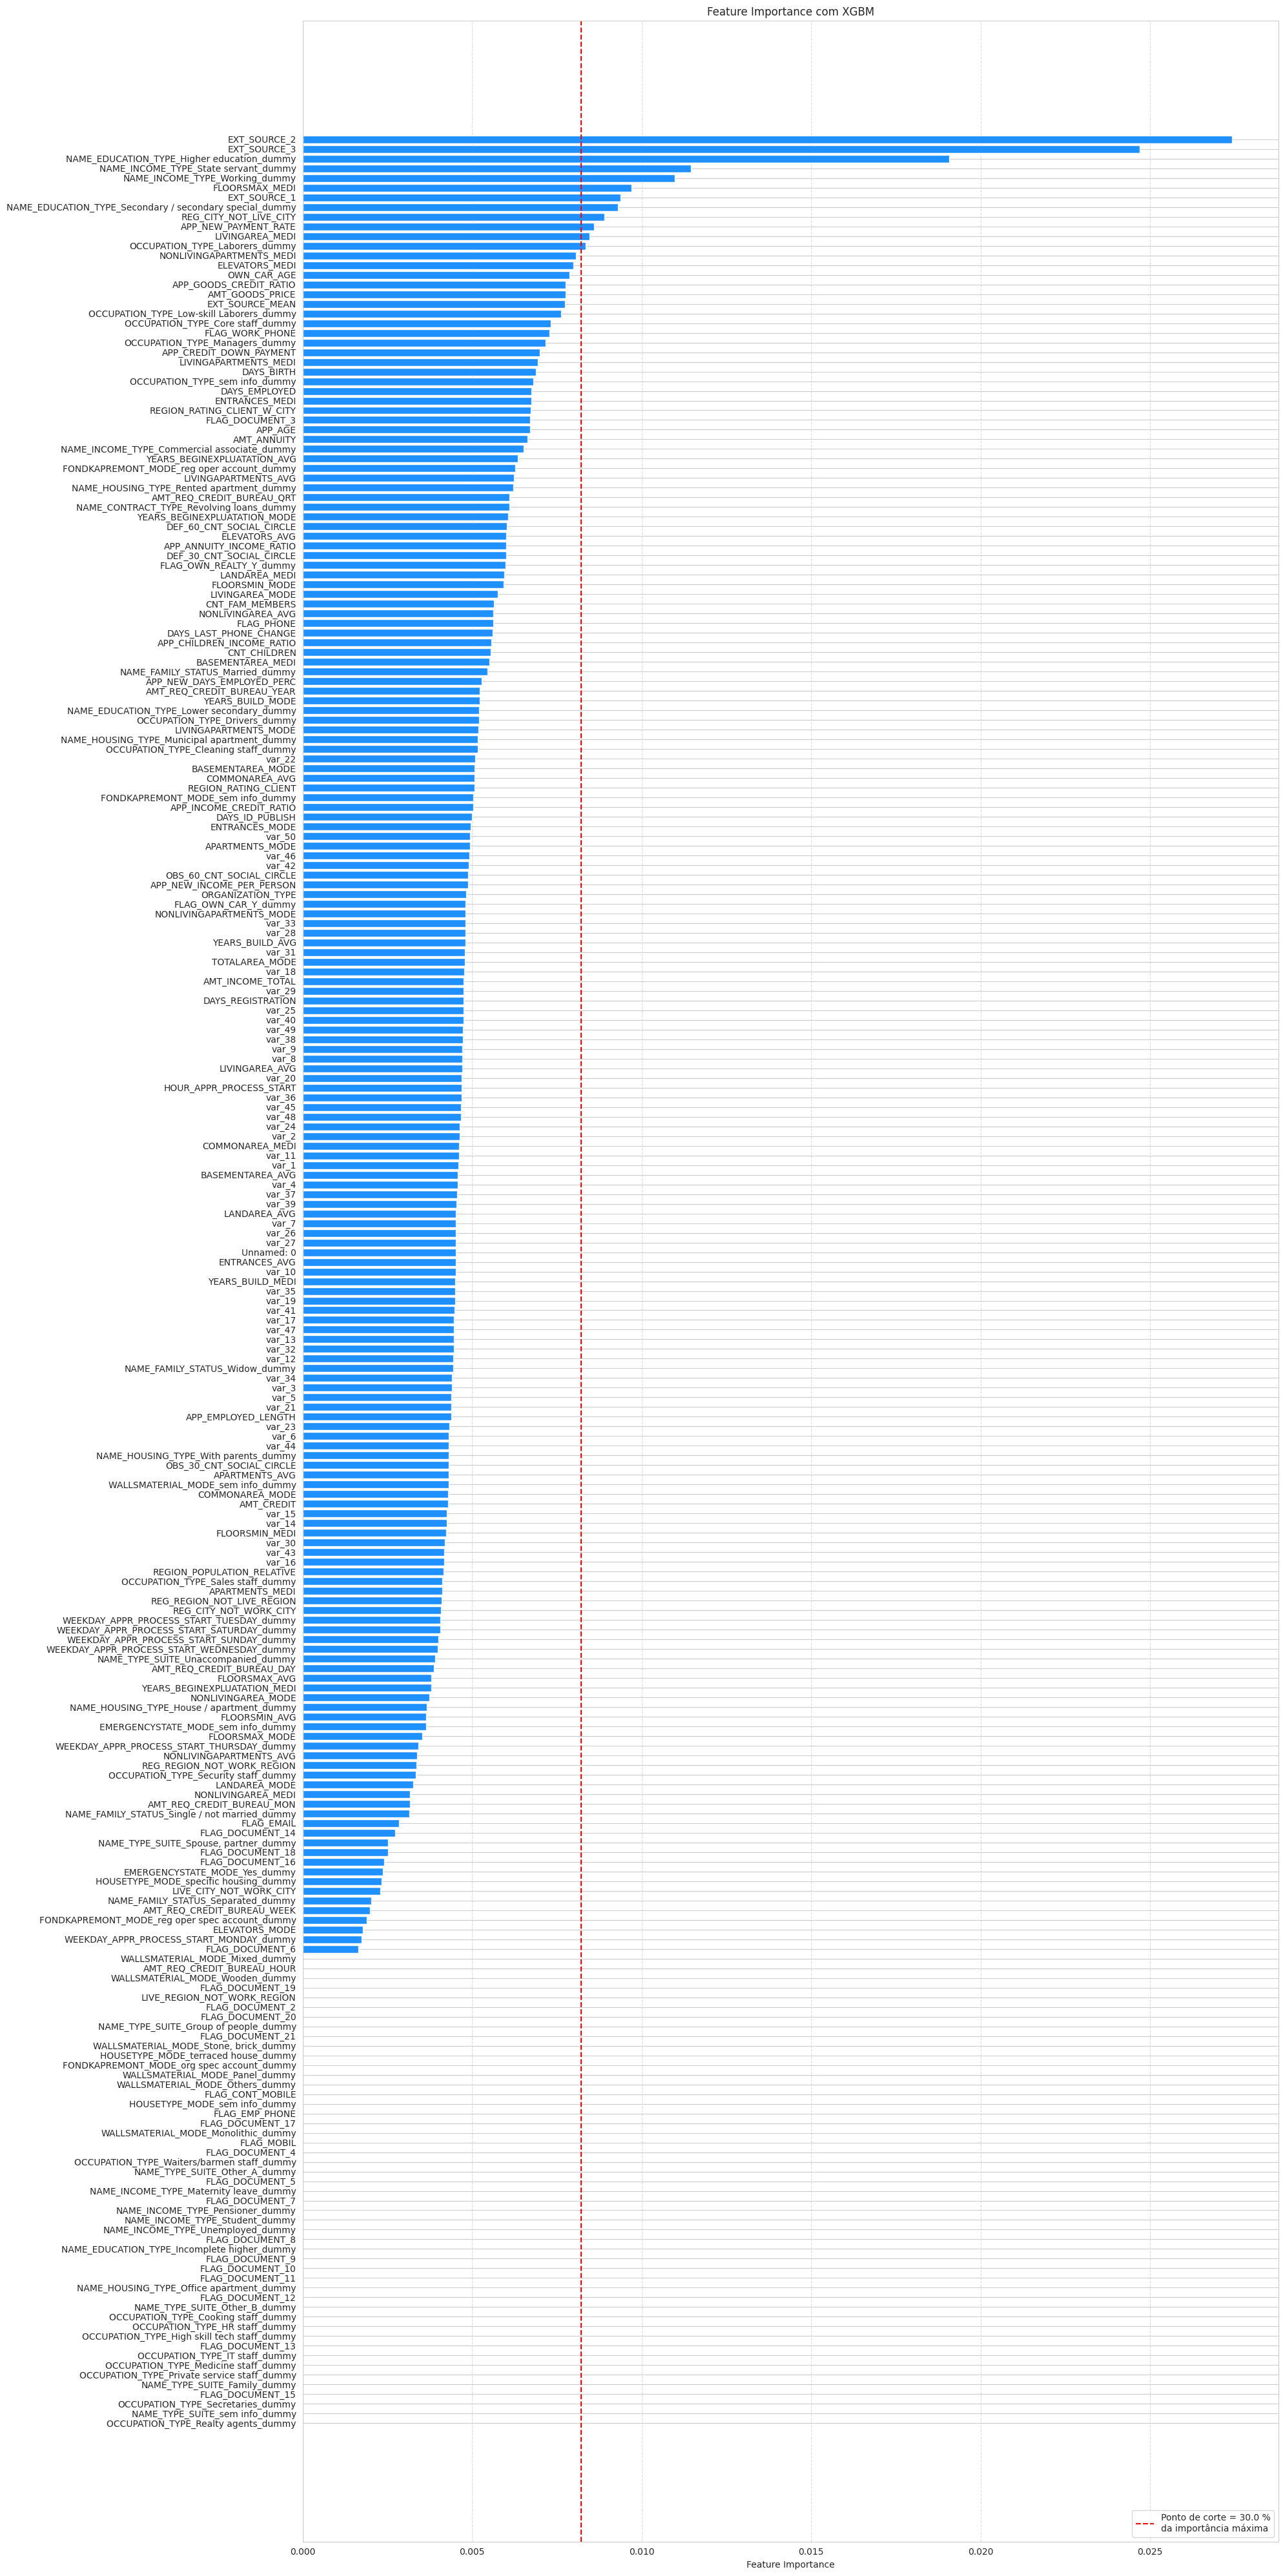

In [95]:
# Calculando e visualizando a Feature Importance

# Definição do modelo
import xgboost as xgb
model = xgb.XGBClassifier(random_state=42)


# Chamando a função
lista_fs_importance_01 = fs_importance(model = model,
                                       X = X_train_01 ,
                                       y = y_train_01 ,
                                       cutoff_importance = 0.30,
                                       plot=True,
                                       figsize=(20,40),
                                       model_name='XGBM')

In [96]:
# Variáveis selecionadas
# Incluindo variáveis dummy
lista_fs_importance_01

['REG_CITY_NOT_LIVE_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'APP_NEW_PAYMENT_RATE',
 'NAME_INCOME_TYPE_State servant_dummy',
 'NAME_INCOME_TYPE_Working_dummy',
 'NAME_EDUCATION_TYPE_Higher education_dummy',
 'NAME_EDUCATION_TYPE_Secondary / secondary special_dummy',
 'OCCUPATION_TYPE_Laborers_dummy']

In [97]:
# Removendo sufixo "_dummy" e mantendo apenas a parte anterior à penúltima '_'
lista = [item.rsplit('_', 2)[0] if item.endswith('_dummy') else item for item in lista_fs_importance_01]

# Convertendo para conjunto para remover duplicatas e convertendo novamente para lista
lista = list(set(lista))

# Exibindo a lista sem duplicatas
lista

['APP_NEW_PAYMENT_RATE',
 'EXT_SOURCE_3',
 'REG_CITY_NOT_LIVE_CITY',
 'OCCUPATION_TYPE',
 'FLOORSMAX_MEDI',
 'NAME_EDUCATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_1',
 'LIVINGAREA_MEDI',
 'NAME_INCOME_TYPE']

In [98]:
# Verificando a Information Value para as variáveis
selected_vars_iv , df_iv = select_features_by_iv_discretized(abt_train_01[lista_fs_importance_01 + ['TARGET']], target='TARGET')

Calculating IV: 100%|██████████| 13/13 [00:00<00:00, 18.01variable/s]


In [99]:
# Visualizando
pd.set_option('display.max_rows', None)
df_iv.head(10)

,Variable,IV,Predictiveness
2,EXT_SOURCE_2,0.322743,Forte
3,EXT_SOURCE_3,0.288647,Moderado
1,EXT_SOURCE_1,0.151809,Moderado
6,APP_NEW_PAYMENT_RATE,0.105609,Moderado
8,NAME_INCOME_TYPE_Working_dummy,0.044418,Fraco
9,NAME_EDUCATION_TYPE_Higher education_dummy,0.042663,Fraco
10,NAME_EDUCATION_TYPE_Secondary / secondary special_dummy,0.032516,Fraco
4,FLOORSMAX_MEDI,0.029654,Fraco
11,OCCUPATION_TYPE_Laborers_dummy,0.027249,Fraco
5,LIVINGAREA_MEDI,0.022456,Fraco


In [100]:
# Criando a partir da tabela original, mas somente com as colunas selecionadas
abt_02 = abt_00[lista + ['TARGET', 'SK_ID_CURR']]

# Metadados
metadados_02 = report_data(abt_02)
metadados_02


  Quantidade de linhas duplicadas: 0  |  Quantidade de features com valores faltantes: 7
  Quantidade de features numéricas: 9  |  Quantidade de features categóricas 3
  Cardinalidade total das categóricas: 31  |  Dataframe: 129155 linhas, 12 colunas
        


,Feature,Tipo,Card,%Miss,%Out_sup,%Out_inf,%Outliers,Moda,%Freq
0,APP_NEW_PAYMENT_RATE,float64,25865,0.0,5.2,0.0,5.2,0.05,9.5
1,EXT_SOURCE_3,float64,786,19.8,0.0,0.0,0.0,0.7463,0.5
2,REG_CITY_NOT_LIVE_CITY,int64,2,0.0,7.8,0.0,7.8,0.0,92.2
3,OCCUPATION_TYPE,object,18,31.4,0.0,0.0,0.0,Laborers,18.0
4,FLOORSMAX_MEDI,float64,47,49.6,1.8,0.0,3.6,0.1667,20.6
5,NAME_EDUCATION_TYPE,object,5,0.0,0.0,0.0,0.0,Secondary / secondary special,71.0
6,EXT_SOURCE_2,float64,77218,0.2,0.0,0.0,0.0,0.285898,0.2
7,EXT_SOURCE_1,float64,52606,56.4,0.0,0.0,0.0,0.405015,0.0
8,LIVINGAREA_MEDI,float64,4643,50.0,4.2,0.0,8.4,0.0521,0.1
9,NAME_INCOME_TYPE,object,8,0.0,0.0,0.0,0.0,Working,51.7


In [101]:
# Aplicando novo dataprep
dataprep_03 = dataprep_out_of_sample(df=abt_02,
                                     target='TARGET',
                                     col_id = 'SK_ID_CURR',
                                     metadados=metadados_02,
                                     encoder_method = 'onehot+label',
                                     scaled=True,
                                     random_state=2)

In [102]:
# Resumo do dataprep
print(dataprep_03.resume)

Resumo dataprep:

      • Limite de cardinalidade adotado: 20
      • Limite de percentual de nulos adotado: 70%
      • Quantidade de variáveis dropadas por nulos: 0
      • Quantidade de variáveis ao qual foi aplicado OneHotEncoder: 3
      • Quantidade de variáveis ao qual foi aplicado LabelEncoder: 0
      • Quantidade de variáveis ao qual foi aplicado StandardScaler: 36


In [103]:
# Restaurando os dados de treino (redução do nome para facilidade)

# Treino
X_train_03 = dataprep_03.X_train_enc
y_train_03 = dataprep_03.y_train
id_train = dataprep_03.col_id_train

# Teste
X_test_03 = dataprep_03.X_test_enc
y_test_03 = dataprep_03.y_test
id_test = dataprep_03.col_id_test


# Montando a tabela analítica adicionando target e ID

# Treino
abt_train_03 = X_train_03.copy()
abt_train_03['TARGET'] = y_train_03.tolist()
abt_train_03['SK_ID_CURR'] = id_train.tolist()

# Teste
abt_test_03 = X_test_03.copy()
abt_test_03['TARGET'] = y_test_03.tolist()
abt_test_03['SK_ID_CURR'] = id_test.tolist()


# Concatenando
abt_03 = pd.concat([abt_train_03 , abt_test_03] , axis=0, ignore_index=True)

# Exibindo
abt_03.sample(3)

,APP_NEW_PAYMENT_RATE,EXT_SOURCE_3,REG_CITY_NOT_LIVE_CITY,FLOORSMAX_MEDI,EXT_SOURCE_2,EXT_SOURCE_1,LIVINGAREA_MEDI,OCCUPATION_TYPE_Cleaning staff_dummy,OCCUPATION_TYPE_Cooking staff_dummy,OCCUPATION_TYPE_Core staff_dummy,...,NAME_EDUCATION_TYPE_Secondary / secondary special_dummy,NAME_INCOME_TYPE_Commercial associate_dummy,NAME_INCOME_TYPE_Maternity leave_dummy,NAME_INCOME_TYPE_Pensioner_dummy,NAME_INCOME_TYPE_State servant_dummy,NAME_INCOME_TYPE_Student_dummy,NAME_INCOME_TYPE_Unemployed_dummy,NAME_INCOME_TYPE_Working_dummy,TARGET,SK_ID_CURR
112387,0.042636,0.591977,1,0.1667,0.277500,0.508639,0.0749,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,173258
101644,0.029438,0.646330,1,0.2917,0.729303,0.508639,0.1229,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,422109
40672,0.099437,0.795803,0,0.1667,0.415839,0.508639,0.0749,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,270064


In [104]:
# Verificando volumetrias
print(abt_03.shape)
print(abt_train_03.shape)
print(abt_test_03.shape)

(129155, 38)
(90408, 38)
(38747, 38)


In [105]:
# Verificando a correlação entre as variáveis selecionadas
df_aux = X_train_03.copy()
df_aux['TARGET'] = y_train_03


# Calcula a matriz de correlação
correlation_matrix = df_aux.corr()

# Transforma a matriz em um DataFrame com a descrição desejada
correlation_df = pd.DataFrame(columns=['Variável 1 x Variável 2', 'Correlação'])
added_combinations = set()

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        if col1 != col2 and (col1, col2) not in added_combinations and (col2, col1) not in added_combinations:
            correlation_df = correlation_df.append({
                'Variável 1 x Variável 2': f'{col1} x {col2}',
                'Correlação': correlation_matrix.loc[col2, col1]  # Correção na ordem das variáveis
            }, ignore_index=True)
            added_combinations.add((col1, col2))

# Ordena o DataFrame por ordem decrescente de correlação
correlation_df = correlation_df.sort_values(by='Correlação', ascending=False)

# Exibe o resultado
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
correlation_df.head(20)

,Variável 1 x Variável 2,Correlação
594,OCCUPATION_TYPE_sem info_dummy x NAME_INCOME_TYPE_Pensioner_dummy,0.696001
107,FLOORSMAX_MEDI x LIVINGAREA_MEDI,0.627156
310,OCCUPATION_TYPE_Core staff_dummy x NAME_INCOME_TYPE_State servant_dummy,0.219732
433,OCCUPATION_TYPE_Laborers_dummy x NAME_INCOME_TYPE_Working_dummy,0.204427
464,OCCUPATION_TYPE_Managers_dummy x NAME_EDUCATION_TYPE_Higher education_dummy,0.189412
303,OCCUPATION_TYPE_Core staff_dummy x NAME_EDUCATION_TYPE_Higher education_dummy,0.175273
490,OCCUPATION_TYPE_Medicine staff_dummy x NAME_INCOME_TYPE_State servant_dummy,0.158736
195,EXT_SOURCE_1 x NAME_INCOME_TYPE_Pensioner_dummy,0.152546
138,EXT_SOURCE_2 x EXT_SOURCE_1,0.137385
426,OCCUPATION_TYPE_Laborers_dummy x NAME_EDUCATION_TYPE_Secondary / secondary special_dummy,0.133362


In [49]:
# Dropando uma feature com correlação acima de 0.80

# abt_train_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# abt_test_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# X_train_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)
# X_test_03.drop('LIVINGAREA_MEDI' , axis=1 , inplace=True)

# lista_fs_importance_01.remove('LIVINGAREA_MEDI')
# lista.remove('LIVINGAREA_MEDI')

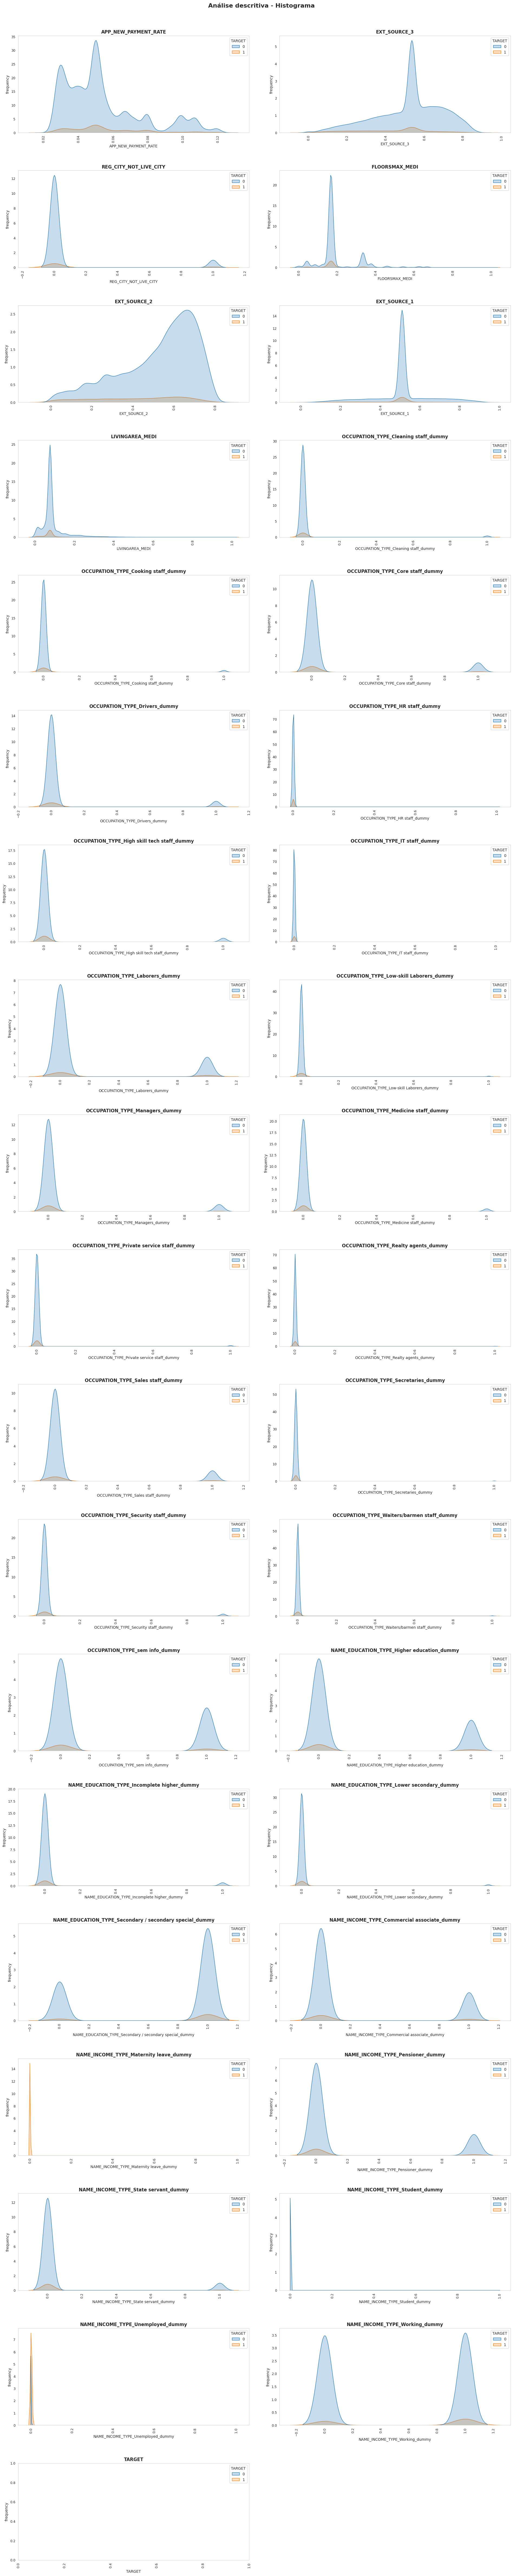

In [106]:
# # Visualizando a dstribuição das features selecionadas em relação à target
plot_batch_histogram(df_aux, cols=2, hue='TARGET', color = 'deepskyblue', b=20)

##Modelagem

In [107]:
# Intanciando o modelo

# Xtreme Gradient Boosting
import xgboost as xgb
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [108]:
# Modelo baseline

# Treinando o modelo
model.fit(X_train_03, y_train_03)

# Previsões nos dados de treino
y_train_pred = model.predict(X_train_03)
y_train_pred_prob = model.predict_proba(X_train_03)

# Previsões nos dados de teste
y_pred = model.predict(X_test_03)
y_pred_prob = model.predict_proba(X_test_03)

In [109]:
# Tabela de métricas
df_metrics = calculate_metrics('Métricas', model, X_train_03, y_train_03, X_test_03, y_test_03)

# Exibindo
df_metrics

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,Métricas,Treino,0.923978,0.880282,0.068446,0.863692,0.727384,0.557104
1,Métricas,Teste,0.918574,0.463277,0.026098,0.736246,0.472492,0.355919


In [248]:
# Tunagem de hiperparâmetros

# # Definindo os parâmetros para o grid search do XGBM
grid_param = {
    'objective': ['binary:logistic'],
    'learning_rate': [0.1 , 0.00001], #[0.01, 0.1]
    'max_depth': [3],  #[3, 5],
    'min_child_weight': [4], #[1, 3]
    'subsample': [0.5 , 1.0], #[0.5, 0.7, 1.0]
    'colsample_bytree': [0.5 , 1], #[0.5, 0.7]
    'n_estimators': [200], #[10, 100]
    'scale_pos_weight': [11.5], # 0.92 /0.08 = +/- 11
    'reg_lambda':[0.5, 1.5 , 3],
    'reg_alpha':[0.5, 1.5 , 3]}

# Chamando o GridSearch
grid = GridSearchCV(model, grid_param, cv=5, scoring='roc_auc', n_jobs=-1)  # 'accuracy' 'precision' 'recall' 'f1' 'roc_auc'

# Treinando o modelo com GridSearch
grid.fit(X_train_03, y_train_03)

# Obtendo o melhor modelo
model_opt = grid.best_estimator_

# ------------------------------------------------------
# XGBoosting sem GridSearch
# model_opt = xgb.XGBClassifier(learning_rate= 0.01,
#                               colsample_bytree=0.7,
#                               max_depth= 3,
#                               min_child_weight= 3,
#                               n_estimators= 300,
#                               subsample=0.7,
#                               objective='binary:logistic',
#                               scale_pos_weight= 2,   # paramêtro do peso das classes. Valor ideal
#                               )


# model_opt.fit(X_train_03, y_train_03)

In [249]:
# Melhor score encontrado
print(f'roc_auc = {grid.best_score_}')

roc_auc = 0.7452550283090433


In [250]:
# Visualizando os melhores hiperparâmetros
grid.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 4,
 'n_estimators': 200,
 'objective': 'binary:logistic',
 'reg_alpha': 3,
 'reg_lambda': 0.5,
 'scale_pos_weight': 11.5,
 'subsample': 1.0}

In [259]:
# Calculando e visualizando as métricas
df_metrics_opt = calculate_metrics('Métricas', model_opt, X_train_03, y_train_03, X_test_03, y_test_03)
df_metrics_opt

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,Métricas,Treino,0.696255,0.167612,0.695688,0.764991,0.529981,0.392706
1,Métricas,Teste,0.696389,0.165658,0.679822,0.753245,0.506490,0.381125


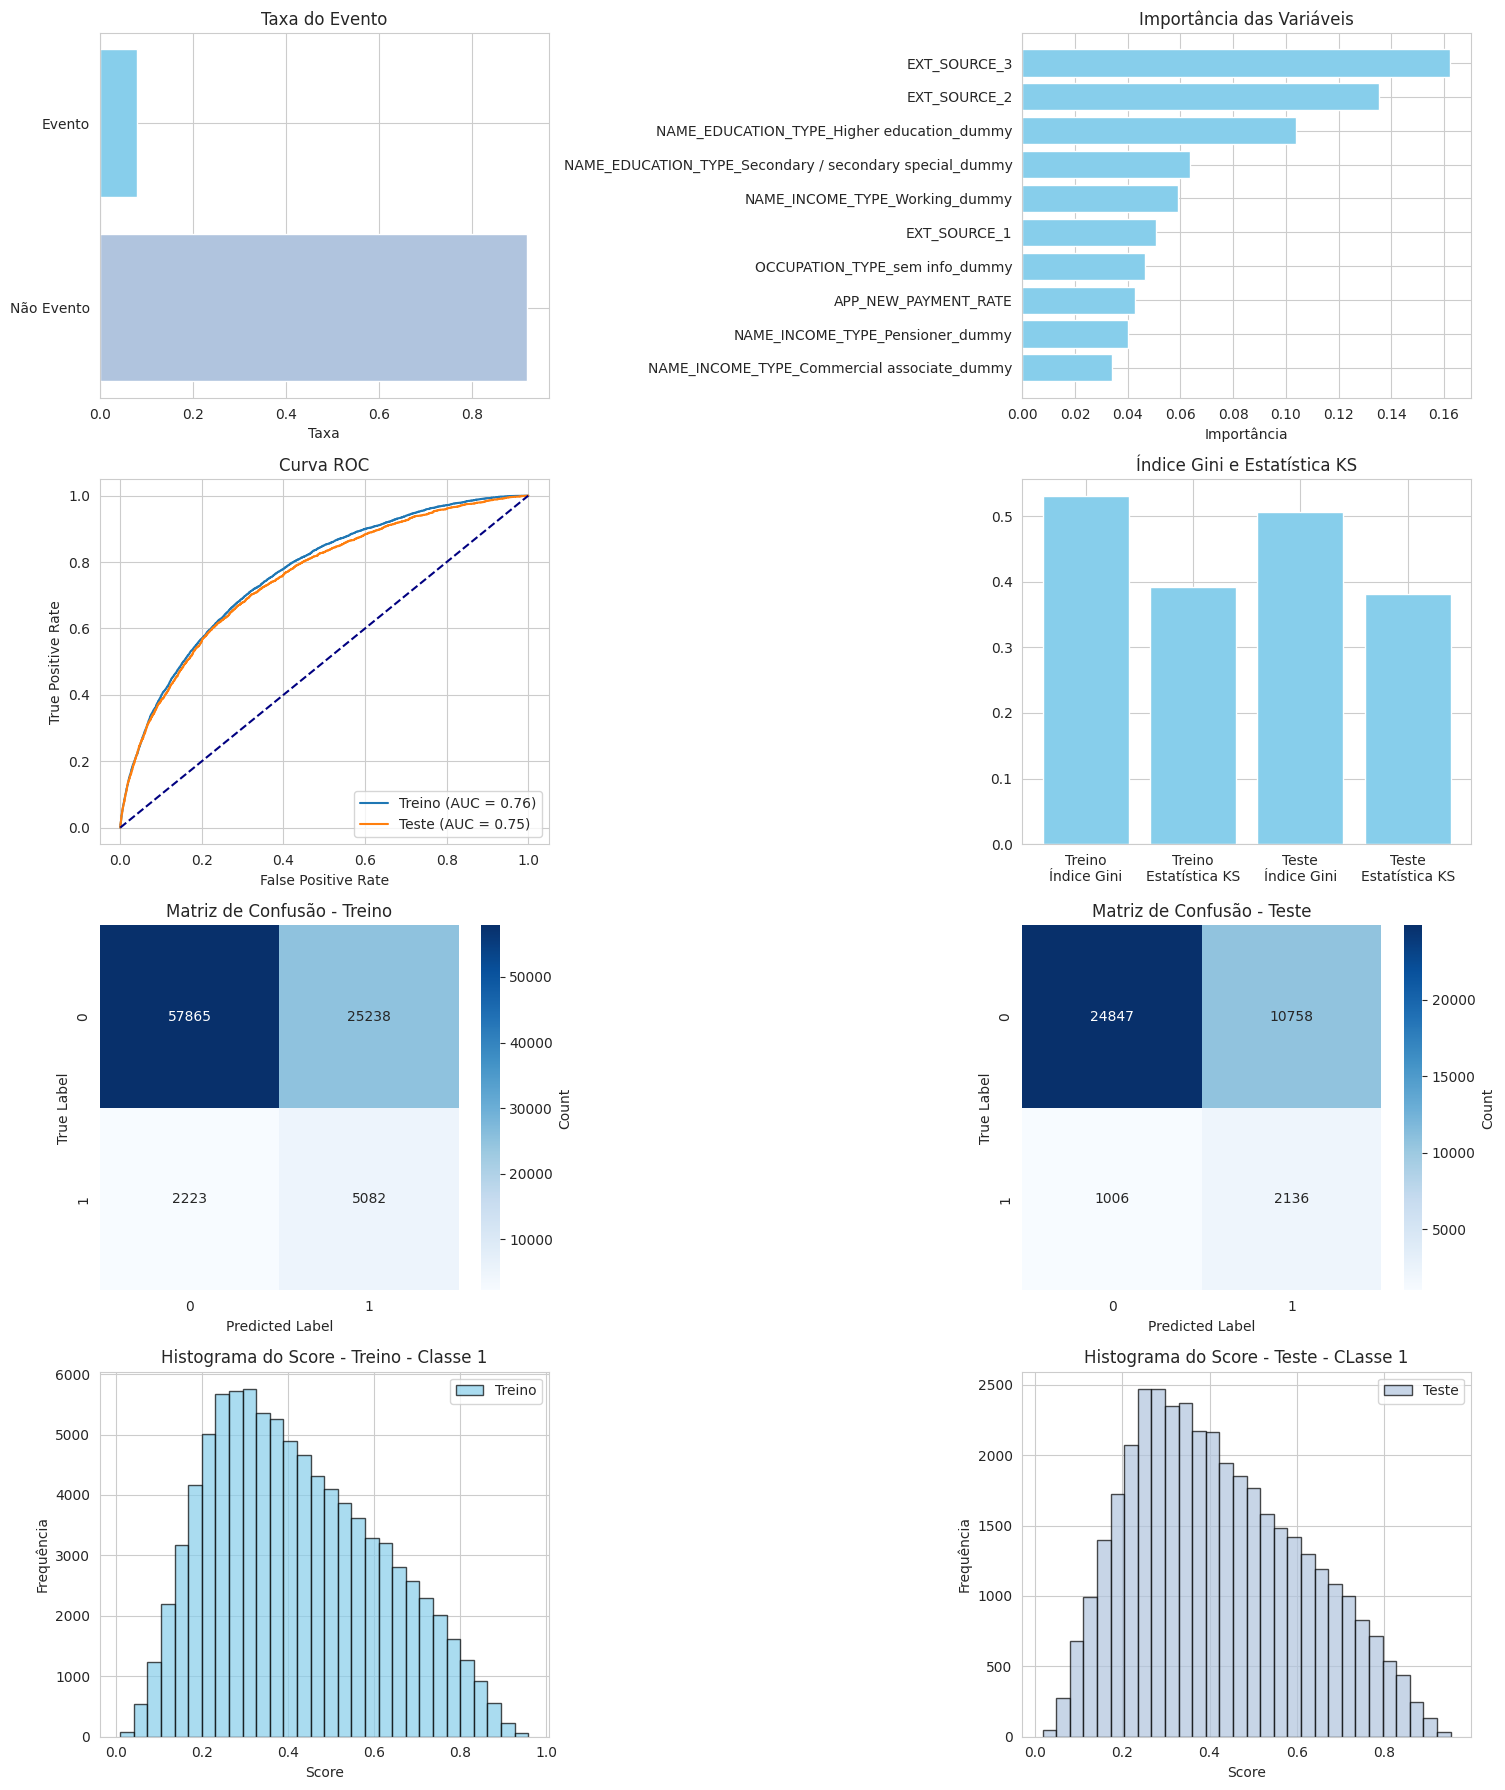

In [260]:
# Visualizando as métricas
plot_metrics(model_opt, X_train_03, y_train_03, X_test_03, y_test_03)

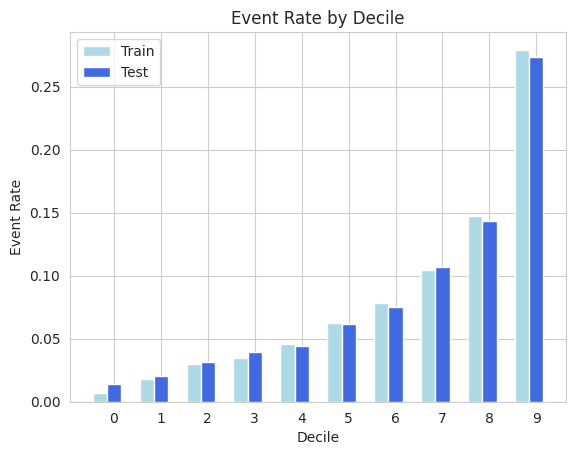

,Metric,Train Value,Test Value
0,KS,0.392706,0.381125
1,AUC,0.764991,0.753245
2,Gini,0.529981,0.506490


In [261]:
# Conjunto de dados auxiliares para visualização dos deciles no mesmo plot
# (para não alterar os conjuntos X_train / X_test)

aux_train = X_train_03.copy()
aux_train['Score_0'] = model_opt.predict_proba(X_train_03)[:,0]
aux_train['Score_1'] = model_opt.predict_proba(X_train_03)[:,1]
aux_train['TARGET PRED'] = model_opt.predict(X_train_03)
aux_train['TARGET REAL'] = y_train_03.values

aux_test = X_test_03.copy()
aux_test['Score_0'] = model_opt.predict_proba(X_test_03)[:, 0]
aux_test['Score_1'] = model_opt.predict_proba(X_test_03)[:, 1]
aux_test['TARGET PRED'] = model_opt.predict(X_test_03)
aux_test['TARGET REAL'] = y_test_03.values

metrics, ord_score_train, vord_score_test = calculate_metrics2 (aux_train, aux_test, 'Score_1', 'TARGET REAL' , bins=10)
metrics

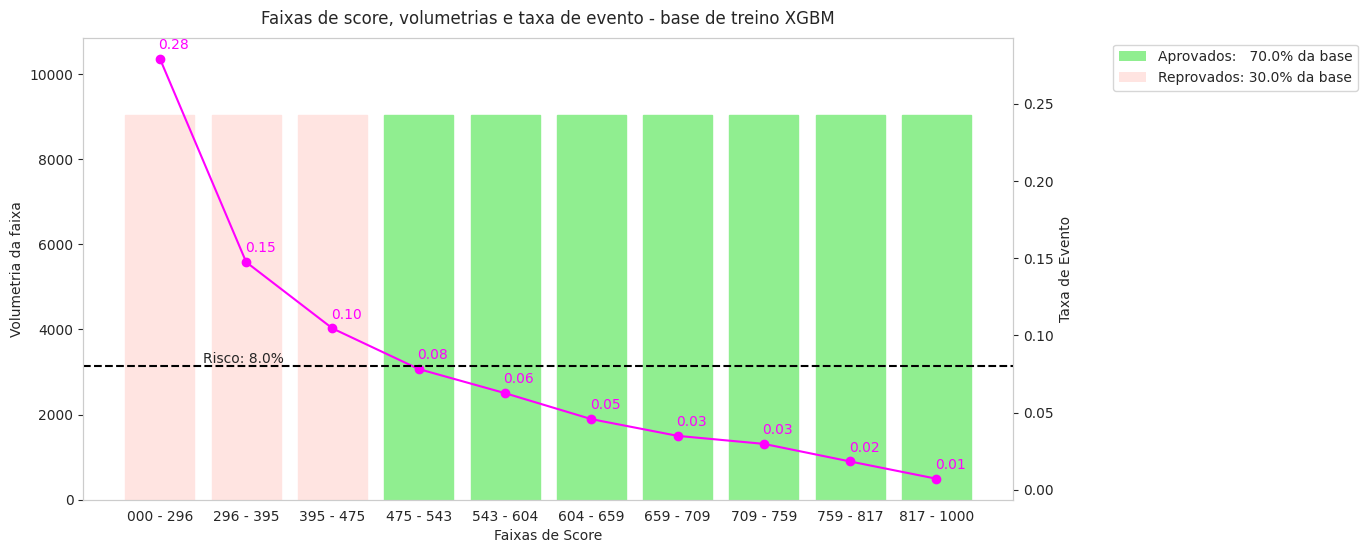

In [274]:
# Análise da carteira dos dados de treino
faixas = carteira_treino(model=model_opt, name_model='XGBM',
               risk = 0.08, X_train = X_train_03, y_train = y_train_03)

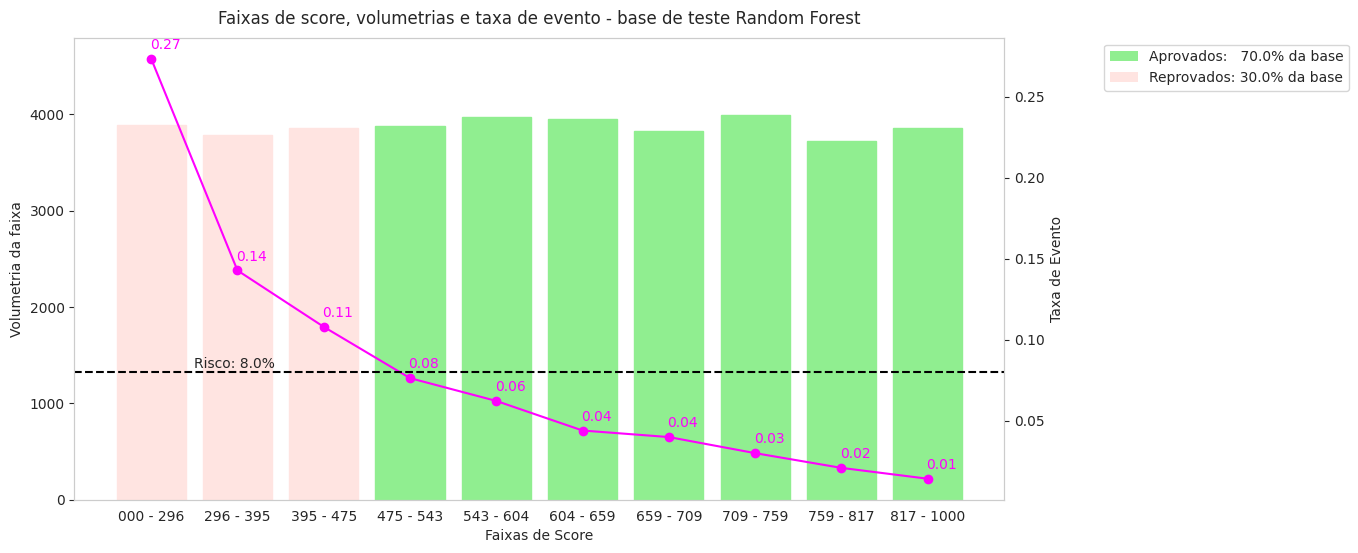

In [275]:
# Análise da carteira dos dados de treino
carteira_teste(faixas=faixas, model=model_opt, name_model='Random Forest',
               risk = 0.08, X_test = X_test_03, y_test = y_test_03)

In [264]:
# Salvando os artefatos do modelo

# Último dataprep
dataprep = dataprep_03

# path da pasta
path = '/content/drive/MyDrive/Colab Notebooks/Projetos pessoais/01. Projetos Machine Learning/Hackaton PoD Academy - Novembro 2023/Artefatos/'

# Prefixo da base
base='v03'

# Nome do modelo
model = model_opt


# Exporta o modelo
with open(f'{path}model_{base}.pkl', 'wb') as f:
    pickle.dump(model, f)

# Exporta lista das features orginais selecionadas
with open(f'{path}features_{base}.pkl', 'wb') as f:
    pickle.dump(lista, f)

# Exporta lista da Feature Importance
with open(f'{path}features_fs_{base}.pkl', 'wb') as f:
    pickle.dump(lista_fs_importance_01, f)

# Exporta dicionário de valores para imputação
with open(f'{path}inputs_miss_{base}.pkl', 'wb') as f:
    pickle.dump(dataprep.list_miss_input, f)

# Exporta lista de variáveis submetidas ao OneHotEncoder
with open(f'{path}list_onehotencoder_{base}.pkl', 'wb') as f:
    pickle.dump(dataprep.list_var_OneHotEncoder, f)

# Objeto OneHotEncoder
with open(f'{path}encoder_{base}.pkl', 'wb') as f:
    pickle.dump(dataprep.one_hot_enc, f)


# Salva as tabelas
X_train_03.to_csv(f'{path}X_train_03.csv' , index=False)
X_test_03.to_csv(f'{path}X_test_03.csv' , index=False)
y_train_03.to_csv(f'{path}y_train_03.csv' , index=False)
y_test_03.to_csv(f'{path}y_test_03.csv' , index=False)

##Escoragem da tabela

In [265]:
# Transformação de tabela bruta


# =========================================================
# Parâmetros
# =========================================================

dataprep = dataprep_03
abt_new = df_score.copy()
id = 'SK_ID_CURR'
target = 'TARGET'
model = model_opt
name_file = 'df_submission'


# =========================================================
# 1) Backup da coluna de ID
# =========================================================

bkp_id = abt_new[id]


# =========================================================
# 2) Mantendo as features do último dataprep
# =========================================================

# Lista das features remanescentes
features = list(dataprep.X_train.columns)

# Filtragem
abt_new = abt_new[features]


# =========================================================
# 3) Imputar os valores missing
# =========================================================

# Dicionário de valores para imputação
val_to_fill = dataprep.list_miss_input

# Prenchimento de missing
abt_new = abt_new.fillna(value=val_to_fill)


# =========================================================
# 4) Aplicar o encoder
# =========================================================

# Lista de variáveis submetidas ao OneHotEncoder
list_one_hot_encoder = dataprep.list_var_OneHotEncoder

# Lista de variáveis submetidas ao LabelEncoder
list_label_encoder = dataprep.list_var_LabelEncoder

# Objeto OneHotEncoder
one_hot_encoder = dataprep.one_hot_enc

# Dicionário de objetos LabelEncoder
label_encoder = dataprep.label_enc

# Aplicando o OneHotEncoder (Lembrar de aplicar o sufixo '_dummy')
encoded_data = one_hot_encoder.transform(abt_new[list_one_hot_encoder])
encoded_cols = one_hot_encoder.get_feature_names_out(list_one_hot_encoder)
encoded_df = pd.DataFrame(encoded_data, columns=encoded_cols+'_dummy', index=abt_new.index)
abt_new = pd.concat([abt_new.drop(list_one_hot_encoder, axis=1), encoded_df], axis=1)

# Aplicando o LabelEncoder
for chave, valor in label_encoder.items():
    abt_new[chave] = valor.transform(abt_new[chave])


# =========================================================
# 5) Aplicar o scaler
# =========================================================

# Lista de variáveis submetidas ao StandardScaler
# list_scaler = dataprep.list_var_scaled

# Objeto StandardScaler
# scaler = dataprep.scaler

# Aplicando o scaler
# abt_new = pd.DataFrame(scaler.transform(abt_new), columns=abt_new.columns)


# =========================================================
# 6) Fazendo as predições
# =========================================================

y_pred = model.predict(abt_new)


# =========================================================
# 7) Gerando tabela escorada
# =========================================================

abt_final = pd.DataFrame()
abt_final['ID'] = bkp_id
abt_final[target] = y_pred

# =========================================================
# 8) Salvando a tabela escorada
# =========================================================

abt_final.to_csv(f'{name_file}.csv', index=False)


# =========================================================
# 9) Download a tabela escorada
# =========================================================

from google.colab import files
files.download(f'{name_file}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [266]:
# Percentuais de classes da base escorada
100 * abt_final['TARGET'].value_counts(1)

0    66.590067
1    33.409933
Name: TARGET, dtype: float64